In [15]:
# Testing Pacman
import postprocess as pp
import plots as plots
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline

from pathlib import Path 

In [55]:
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)


## Analyis helps

In [17]:
def _critical_load(matpar):
    _mu, _k, _w1, _N = matpar["mu"], matpar["k"], matpar["w1"], matpar["N"]
    return np.sqrt(8*_w1 / (_mu*_k)/4)
    # independent of _N**2


def _homogeneous_state(t, matpar):
    """docstring for _homogeneous_state"""
    _mu, _k, _w1, _N = matpar["mu"], matpar["k"], matpar["w1"], matpar["N"]


    # _tc = np.sqrt(matpar/k)
    # _a = (tau - 1) / (_k - 1)

    _tc = _critical_load(params["model"])
    _uh = [0 for i in range(0, _N+1)]
    
    if t <= _tc:
        # elastic
        _alphah = [0. for i in range(0, _N)]
        _uh = [i*t/_N for i in range(0, _N+1)]
    else:   
        # damaging
        _α = (t/_tc - 1) / (_k - 1)
        _alphah = [_α for i in range(0, _N)]

        # _S = reduce(lambda a, b: a+b, list(map(a_atk, _alphah)))
        
        _S = _N*a_atk(_α)

        _e = t / _N
        for i in range(0, _N+1):
            if i == 0:
                _uh[i] = 0
            else: 
                _uh[i] = _e * i
        # _uh = [a_atk(_α) / (_N*a_atk(_α)) * i/_N for i in range(0, _N+1)]
        # print(t, _e)
    return _alphah, _uh

In [155]:
class DefaultDamage:
    def __init__(self, state, matpar, name = "Default damage model: atk aka JJK aka LS", slug = "atk"):
        self.state = state
        self.matpar = matpar
        self.str = name
        self.slug = slug


    def _a(self, α):
        _α = self.state[α]
        # _α = α
        # _E0 = self.matpar[E0]
        _k = self.matpar[k]

        return (1 - α) / ((_k-1) * α + 1)

    def _w(self, _α):
        _α = α
        # _w1 = self.matpar[w1]

        return _α

    def energy(self, state):
        """Total energy"""
        return self._elastic(state) + self._damage(state) - self.work(state)

    def work(self, state):
        return 0

    def _elastic(self, state):
        _E0 = self.matpar[E0]
        _u = state[u]
        _α = state[α]

        return 1./2. * _E0 * self._a(_α) * sp.diff(_u, x)**2 

    def _damage(self, state):
        _α = state[α]
        _w1 = matpar[w1]
        _𝓁 = matpar[𝓁]

        return _w1 * (self._w(_α) + matpar[𝓁]**2 * (sp.diff(_α, x))**2 )


    def __str__(self):
     return self.str


class DamageATSN(DefaultDamage):
    """docstring for Model"""
    def __init__(self, state, matpar, name = "ATk Damage Model, Seb Neukirch", slug = "atsn"):
        super(DefaultDamage, self).__init__(matpar, name = name)

    def _a(self, state):
        α = state[α]
        _E0 = self.matpar[E0]

        # return (1 - α)**2

    def _w(self, _α):
        _α = α
        _n = self.matpar[n]
        return 1-(1.-_α)**2


class DamageATn(DefaultDamage):
    """docstring for Model"""
    def __init__(self, state, matpar, slug, name = "ATn Damage Model"):
        super(DamageATn, self).__init__(state, matpar, name = name, slug = slug)

    def _a(self, α):
        return (1 - α)**2

    def _w(self, _α):
        _α = α
        _n = self.matpar[n]
        return _α**_n


class DamagePQ(DefaultDamage):
    """Particularly interesting model, as per marigo-2012"""
    def __init__(self, state, matpar = None, slug = "pq", name = "PQ Damage Model"):
        if matpar == {}:
            if matpar is None:
                p, q, E0, L, w1, 𝓁, σc = sp.symbols('p q E0 L w1 𝓁 σc')
                matpar = {p: p, q: q, E0: E0, w1: w1, 𝓁: 𝓁, L: L, σc: σc}

            self.matpar = matpar
            # TODO: fix redundancies, like below
            # self.matpar = _matpar

        super(DamagePQ, self).__init__(state, matpar, name = "PQ Damage Model", slug = slug)

    def _a(self, α):
        _q = self.matpar[q]
        _p = self.matpar[p]

        return (1 - α)**_q / (1 + α)**_p  

    def _w(self, _α):
        
        
        _α = α
        _q = self.matpar[q]
        _p = self.matpar[p]
        _σc = self.matpar[σc]
        _E0 = self.matpar[E0]

        return (_p+_q) * _α * _σc**2 / _E0


class DamagePQ2(DefaultDamage):
    """Particularly interesting other model, as per marigo-2012, 
        Requires: q > p > 0
    """
    def __init__(self, state, matpar = {}, slug = "pq2", name = "PQ Damage Model"):
        if matpar == {}:
            p, q, E0, L, w1, 𝓁, σc = sp.symbols('p q E0 L w1 𝓁 σc')
            _matpar = {p: p, q: q, E0: E0, w1: w1, 𝓁: 𝓁, L: L, σc: σc}
            self._matpar = _matpar
            # TODO: fix redundancies, like below
            # self.matpar = _matpar

        super(DamagePQ, self).__init__(state, _matpar, name = "PQ Damage Model", slug = slug)

    def _a(self, α):
        _q = self._matpar[q]
        _p = self._matpar[p]

        return (1 - α)**_q 

    def _w(self, _α):
        
        _α = α
        _q = self._matpar[q]
        _p = self._matpar[p]
        _σc = self._matpar[σc]
        _E0 = self._matpar[E0]

        return _q * _σc**2 / (2.* _p * _E0)  * (1.-(1.-_α)**_p)


class PerfectBrittle(DefaultDamage):
    """Perfectly brittle model, as per marigo-2012, 
        w'/E' is constant
    """
    def __init__(self, state, matpar = {}, name = "PQ Damage Model", slug = "pq3"):
        if matpar == {}:
            p, q, E0, L, w1, 𝓁, σc = sp.symbols('p q E0 L w1 𝓁 σc')
            _matpar = {p: p, q: q, E0: E0, w1: w1, 𝓁: 𝓁, L: L, σc: σc}
            self._matpar = _matpar
            # TODO: fix redundancies, like below
            # self.matpar = _matpar

        super(DamagePQ, self).__init__(state, _matpar, name = "PQ Damage Model", slug = "pq3")

    def _a(self, α):
        _q = self._matpar[q]
        _p = self._matpar[p]

        # return (1 - α)**_q 
        # return ?

    def _w(self, _α):
        
        _α = α
        _σc = self._matpar[σc]
        _E0 = self._matpar[E0]
        _ec = _σc / _E0

        return _E0 * (1 - self._a) * _ec**2 /2.


In [69]:
## Simple Analytic 
# import visuals
E0, L, w1, 𝓁, σc = sp.symbols('E0 L w1 𝓁 σc')
# k = sp.symbols('k', integer = True)
x, t = sp.symbols('x t')
α = sp.Function('α')(x)
u = sp.Function('u')(x)


### Homogeneous sound solution
<!-- u = tx -->
<!-- alpha = 0 -->

In [275]:
class ModelAnalysis:
    """Helper class to analyse stability properties of a model"""

    def __init__(self, model):
        self.model = model
        self.state = model.state
        self.matpar = model.matpar

        self._s = 1/self.model._a(state[α])
        self._sp = sp.diff(self._s, state[α], 1)
        self._spp = sp.diff(self._s, state[α], 2)

        self._a = self.model._a(state[α])
        self._ap = sp.diff(self._a, state[α], 1)
        self._app = sp.diff(self._a, state[α], 2)

        self._w = self.model._w(state[α])
        self._wp = sp.diff(self._w, state[α])
        self._wpp = sp.diff(self._w, state[α], 2)

    def _print_model_functions(self, matpar = {}):
        if matpar == {}:
            _fname = f"model-{self.model.slug}.txt"
        else: 
            _fname = f"model-{self.model.slug}-matpar.txt"
        print(f"Output in {_fname}")

        sp.latex(self._a)
        sp.latex(self._ap)
        sp.latex(self._app)
        sp.latex(self._s)
        sp.latex(self._sp)
        sp.latex(self._spp)
        
        _fcs = [self._a.subs(matpar), 
            self._ap.subs(matpar), 
            self._app.subs(matpar), 
            self._s.subs(matpar), 
            self._sp.subs(matpar), 
            self._spp.subs(matpar)]
        _lab = ["a", "aprime", "apprime", "s", "sprime", "spprime"]
        _known = ["a(\\alpha)=", "a'(\\alpha)=", "a''(\\alpha)=", 
                "s(\\alpha)=", "s'(\\alpha)=", "s''(\\alpha)="]

        out_file = open(_fname,"w")
        
        for y in zip(_fcs, _lab, _known):
            _tex = y[2] + str(sp.latex(y[0])).replace("α", "\\alpha")
            out_file.write("\\begin{equation}")
            out_file.write(f"\\label{{ eqn:{self.model.slug}-{y[1]} }}")
            out_file.write(_tex)
            out_file.write("\\end{equation}")
            out_file.write("\n")

        out_file.close()

        _σ = sp.symbols('σ')
        _β = sp.symbols('β')
        _α0 = sp.symbols('α0')
        _γ = sp.symbols('γ')
        _E0 = self.model.matpar[E0]

        _fch = self._H_damage_profile()

        fc0 = self.criterion()
        fc1 = self.critical_load()
        fc3 = _fch.subs(matpar).subs({_β: _α0*_γ})
        fc4 = (1/sp.sqrt(
                _fch.subs(matpar))
                ).simplify()
        fc5 = ((self._s - 1/E0).subs(α, _β)/sp.sqrt(_fch))    \
            .subs(matpar)                                              \
            .simplify()

        fc6 = (((self._s - 1/E0).subs(α, _β)/sp.sqrt(_fch)))    \
            .subs(matpar).subs({_β: _α0*_γ})                \
            # .simplify()
        
        fc7 = _fch.subs(matpar).subs({_β: _α0*_γ})
        fc7_γ = sp.diff(fc7, _γ).subs({_γ: 1}).simplify()
        # Hσγ_γ.simplify()
        fc6_γ = sp.diff(fc6, _γ).subs({_γ: 1}).simplify()

        _fcs = [fc0, fc1, _fch, 
                # fc2, 
                fc3, fc4, fc5, fc6, fc7, fc7_γ, fc6_γ]
        _lab = ["crit", "crit_load", "Hsigmabeta", 
                # "Hsigmagamma", 
                "Hsigmabeta_mat", "one_over_H",
                "eps_integrand", 
                "eps_integrand_gamma", 
                "deriv_integrand_gamma", 
                "deriv_integrand_gamma_one", 
                "deriv_integrand_gamma_one", 
                ]
        _known = ["0=", "t_c=", 
                "H(\\sigma, \\beta)=", 
                # "H(\\sigma, \\beta)=",
                "H(\\sigma, \\gamma)=",
                "1/\\sqrt{H(\\sigma, \\beta)}=",
                "(S(\\beta)-S_0)/\\sqrt{H(\\sigma, \\beta)}=",
                "(S(\\gamma)-S_0)/\\sqrt{H(\\sigma, \\gamma)}=",
                "\\frac{\\partial H}{\\partial \\gamma}=",
                "\\frac{\\partial H}{\\partial \\gamma}|_{\\gamma=1}=",
                "\\frac{\\partial 1/\\sqrt{H}}{\\partial \\gamma}|_{\\gamma=1}="
                ]

        out_file = open(_fname,"a")
        out_file.write("\n")
        
        for y in zip(_fcs, _lab, _known):
            print(y[2])
            _tex = y[2] + str(sp.latex(y[0])).replace("α", "\\alpha") \
                                    .replace("σ", "\\sigma")    \
                                    .replace("β", "\\beta")    \
                                    .replace("γ", "\\gamma")    
            out_file.write("\\begin{equation}")
            out_file.write(f"\\label{{ eqn:{self.model.slug}-{y[1]} }}")
            out_file.write(_tex)
            out_file.write("\\end{equation}")
            out_file.write("\n")

        out_file.close()

    def criterion(self):
        """Damage onset"""
        model, state = self.model, self.state

        _u0 = t*x/L
        _alpha0 = 0

        _crit = sp.diff(model.energy(state), α) \
            .subs({u: _u0, α: _alpha0})         \
            .simplify()
        # .subs(matpar).simplify()
        # _ts = np.array(sp.solve(_crit, t))
        # return np.where(_ts > 0)
        self.crit = _crit

        return _crit

    def _homogeneous_energy(self, _matpar):
        state, (_uf, _af) = self._homogeneous_state(_matpar)

        _u = state[0]
        _alpha = state[1]

        return

    def critical_load(self):
        ans = sp.solve(self.crit, t)
        _ = [t.subs(_matpar) for t in ans]
        positive = np.where(np.array(_) > 0)[0][0]
        # pdx
        self._critical_load = ans[positive]
        return ans[positive]

    def critical_load_N(self, _matpar={}):
        return np.float64(self._critical_load.subs(_matpar))

    def set_critical_load(self, _critical_load):
        self._critical_load = _critical_load

    def _check_constitutive(self):
        _a = 1
        # a -> E(a) decreasing
        # a -> w(a) increasing
        # a -> -w'/E' increasing
        # a -> -w'/s' decreasing
        return

    def _homogeneous_alpha(self, matpar = None):
        _u0 = t*x/L

        if matpar is not None:
            _matpar = matpar
        else:
            _matpar = self.matpar

        try:
            _eq = sp.diff(self.model.energy(state), α) \
                .subs({u: _u0, α: α})         \
                .simplify()

            _ah = sp.solve(_eq, α)

        # except NotImplementedError as e:
        except:
            _eq = sp.diff(ana.model.energy(state), α)   \
                .subs({u: _u0, α: α})                   \
                .subs(_matpar)                   \
                .simplify()

            _ah = sp.solve(_eq, α)

        return _ah

    def plot_homogeneous_alpha(self, _matpar={}):
        ah = self._homogeneous_alpha()
        _tc = self.critical_load_N(_matpar)

        fig, axis = plt.subplots(1, 1, figsize=(8, 6))

        # Plot the zero range
        subcritical_times = np.linspace(0., _tc)
        axis.plot(subcritical_times, [0 for t in subcritical_times], c="C0")

        supercritical_times = np.linspace(_tc, 3)

        for _a in ah:
            _af = sp.lambdify(t, _a.subs(_matpar), "numpy")

            axis.plot(supercritical_times, [_af(t)
                      for t in supercritical_times], c="C0")
            # plt.plot()

        axis.set_xlim(0, 3)
        axis.set_ylim(0, 1)

        plt.axvline(_tc, c='k')
        plt.axhline(1, c='k')

        return fig, axis

    def plot_homogeneous_stress(self, _matpar={}, ah=None):
        ah = self._homogeneous_alpha()
        # _tc = self.critical_load_N(_matpar)
        try:
            _tc = self.critical_load_N(_matpar)
        except:
            _tc = self._critical_load
        print(f"_tc {_tc}")
        fig, axis = plt.subplots(1, 1, figsize=(8, 6))

        # Plot the zero range
        times = np.linspace(0, 3, 30)

        _sf = sp.lambdify(t, self._stress(ah=ah).subs(_matpar), "numpy")

        # axis.plot(np.linspace(0, 3), [_sf(t) for t in times], c="C0")
        axis.plot(_times, [_sf(t) for t in _times], c="C0")

        plt.axvline(_tc, c='k')
        plt.axhline(1, c='k')

        axis.set_xlim(0, 3)
        axis.set_ylim(0, 1)

        return fig, axis

    def _homogeneous_state(self, _matpar={}, ah=None):
        if ah is None:
            # Good luck with the first solution
            _ah = self._homogeneous_alpha()[0]
        else:
            _ah = ah
        try:
            _tc = self.critical_load_N(_matpar)
        except:
            _tc = self._critical_load

        x, t = sp.symbols('x t')
        print(_tc)
        _homogeneous_alpha = sp.Piecewise((_ah, t >= _tc), (0, t < _tc))
        _homogeneous_u = t * x / L

        _uf = sp.lambdify((t, x), _homogeneous_u.subs(_matpar), "numpy")
        _af = sp.lambdify(t, _homogeneous_alpha.subs(_matpar), "numpy")

        state = {u: _homogeneous_u, α: _homogeneous_alpha}

        return state, (_uf, _af)

    def _set_homogeneous_alpha(self, ah):
        self._alpha_h = ah

        return

    def plot_homogeneous_energies(self, _matpar):

        _homog_state, (_uf, _af) = self._homogeneous_state(_matpar)

        _en_h = sp.lambdify(t, at1.energy(_homog_state).subs(
            {α: _homog_state[1]}).subs(_matpar), "numpy")
        _en_dam_h = sp.lambdify(t, at1._damage(_homog_state).subs(
            {α: _homog_state[1]}).subs(_matpar), "numpy")
        _en_ela_h = sp.lambdify(t, at1._elastic(_homog_state).subs(
            {α: _homog_state[1]}).subs(_matpar), "numpy")
        fig, axis = plt.subplots(1, 1, figsize=(8, 6))

        plt.plot(np.linspace(0., 3.), [_en_h(t)
                 for t in np.linspace(0., 3.)], c="C0")
        plt.plot(np.linspace(0., 3.), [_en_dam_h(t)
                 for t in np.linspace(0., 3.)], c="C1")
        plt.plot(np.linspace(0., 3.), [_en_ela_h(t)
                 for t in np.linspace(0., 3.)], c="C2")

        return fig, axis

    def plot_material(self, _matpar):
        _damage = np.linspace(0., 1.)

        _af = sp.lambdify(α, self._a.simplify().subs(_matpar), "numpy")
        _apf = sp.lambdify(α, self._ap.simplify().subs(_matpar), "numpy")
        _appf = sp.lambdify(α, self._app.simplify().subs(_matpar), "numpy")

        # _apf = sp.lambdify(t, ana.)ap.subs(_matpar), "numpy")
        # _apf

        figure, axis = plt.subplots(1, 2, figsize=(8, 6))
        _ax = axis[0]
        _ax.axhline(0, c='k')
        _ax.plot(_damage, [_af(α) for α in _damage], label="a")
        _ax.legend(loc=2)
        # _ax.twiny()
        _ax.plot(_damage, [_apf(α) for α in _damage], label="a'", c='r')
        _ax.plot(_damage, [_appf(α) for α in _damage], label="a''")
        _ax.set_xlim(0, 1)
        _ax.legend()

        _sf = sp.lambdify(α, self._s.simplify().subs(_matpar), "numpy")
        _spf = sp.lambdify(α, self._sp.simplify().subs(_matpar), "numpy")
        _sppf = sp.lambdify(α, self._spp.simplify().subs(_matpar), "numpy")

        _ax = axis[1]

        _ax.plot(_damage, [_sf(α) for α in _damage], label="s")
        _ax.legend(loc=2)
        _ax.axhline(0, c='k')
        _ax.twinx()
        _ax.plot(_damage, [_spf(α) for α in _damage], label="s'")
        _ax.plot(_damage, [_sppf(α) for α in _damage], label="s''")
        _ax.set_xlim(0, 1)
        _ax.set_ylim(0, 10)
        _ax.legend(loc=1)
        figure.suptitle(f"Behaviour of {self.model.__str__()} is Material")

        return figure, axis

    def _hypotheses1(self):
        """As per marigo-2012, HP1: w'/S' decreasing wrt alpha"""

        _hp1 = self._sp / self._wp
        return _hp1

    def _H_damage_profile(self):
        """A function of sigma and beta constructs localisation profiles"""
        _σ = sp.symbols('σ')
        _β = sp.symbols('β')

        _Hf = 1/E0*(2*ana._w - _σ**2 * (ana._s - 1/E0)).subs({α: _β})

        return _Hf

    def _α_max(self, σ, matpar = None):
        _β = sp.symbols('β')
        _σ = sp.symbols('σ')
        # _matpar = self.matpar
        _Hσβ = self._H_damage_profile().subs(matpar)

        _Hβ = _Hσβ.subs({_σ: σ})
        _sol = sp.solve(_Hβ, _β, (0, 1), solver='bisect')
        # print(_sol)
        αmax = np.float64(_sol[1][0])

        return αmax

    def _stress(self, ah=None):
        _homog_state, (_uf, _af) = self._homogeneous_state(_matpar, ah=ah)

        _ah = _homog_state[α]

        _tc = self.critical_load_N(_matpar)

        stress_alpha = sp.Piecewise(
            (sp.sqrt(2 * self._wp / self._sp).subs({α: _ah}), t >= _tc),
            # sigma = E(alpha=0) u'
            (sp.diff(_homog_state[u], x).subs(_matpar), t < _tc))

        # return sp.sqrt( 2* self._wp / self._sp).subs({α: _ah})
        return stress_alpha

    def _Dσ(self, σ):
        """Half length of the localisation as a function of σ"""
        _αh = self._homogeneous_alpha()
        _β = sp.symbols('β')
        _αmax = self._α_max(σ)

        _E0 = self.model._matpar[E0]
        _𝓁 = self.model._matpar[𝓁]

        _f = 1/self._H_damage_profile()

        _Dσ = _𝓁 * sp.integrate(_f, (_β, 0, _αmax))

    def _Dc(self):
        """Half length of the localisation at the onset"""
        _αh = self._homogeneous_alpha()
        _E0 = self.model._matpar[E0]
        _D = np.pi * 𝓁 * \
            sp.sqrt(2 * _E0 / (σ * self._spp - 2.*self._wpp)).subs({α: 0})

    def snap_back(self, matpar):
        _α = self.model.state[α]
        _E0 = self.model.matpar[E0]
        _w1 = self.model.matpar[w1]
        S0 =  1 / _E0
        _σc = sp.sqrt( 2* self.model.matpar[w1]*self._wp / (S0*self._sp) ).subs({α: 0})
        _sp = self._sp
        _w = self._w

    def _eps_1_d(self, σv, matpar, tol = 1e-3):
        # _β = sp.symbols('β')
        # _α_max = self._α_max(σv, matpar)
        # _f = (self._s - 1/E0).subs(α, _β)/sp.sqrt(self._H_damage_profile())    \
        #     .subs(matpar)                                                   \
        #     .subs({_σ: σv})                                                   \
        #     .simplify()

        # __fv = sp.lambdify(_β, f.subs(matpar), "numpy")
        # _tol = 0.001
        _betas = np.linspace(_tol, _α_max - tol, 30)
        _f, _α_max, __fv = self._eps_1_d_integrand(σv, matpar)
        eps = np.trapz([__fv(b) for b in _betas], _betas)

        return eps, (_f, _α_max)

    def _eps_1_d_integrand(self, σv, matpar):
        _β = sp.symbols('β')
        _α_max = self._α_max(σv, matpar)

        _f = ((self._s - 1/E0).subs(α, _β)/sp.sqrt(self._H_damage_profile()))    \
            .subs(matpar)                                                       \
            .subs({_σ: σv})                                                   \
            .simplify()

        __fv = sp.lambdify(_β, _f.subs(matpar), "numpy")

        return _f, _α_max, __fv




        return - ((np.pi * 2**(5/2) * (S0 * _sp)**2 * _σc**2 * _E0**1/2) /
                  (S0*self._spp * _σc**2 - 2. * _w1 * self._wpp) ** (3/2))       \
                    .subs({α: 0}).subs(matpar)

    # check: dependence of localisation zone wrt stress
    # check: global maccro response


In [71]:
E0, L, w1, 𝓁, σc = sp.symbols('E0 L w1 𝓁 σc')
k = sp.symbols('k', integer = True)

x, t = sp.symbols('x t')
α = sp.Function('α')(x)
u = sp.Function('u')(x)

state = {u: u, α: α}

# sp.diff(atk.elastic(state), α).subs({u: _u0}).simplify()



In [72]:
# _times = np.linspace(0., atk.matpar)
_times = np.linspace(0., 3.)
_damage = np.linspace(0., 1.)


## ATk

In [276]:
state = {u: u, α: α}
_matpar = {k: 2, E0: 1, w1: 1, 𝓁:𝓁, L: 1}
matpar = {k: k, E0: E0, w1: w1, 𝓁:𝓁, L: L}

_u0 = t*x/L
_alpha0 = 0 

atk = DefaultDamage(state, matpar)


ana = ModelAnalysis(atk)
_crit = sp.diff(atk.energy(state), α).subs({u: _u0, α: _alpha0}).simplify()
_crit




-0.5*E0*k*t**2/L**2 + 1.0*w1

In [277]:
ana.model.slug

'atk'

In [278]:
ana._print_model_functions(_matpar)
ana._print_model_functions()

Output in model-atk-matpar.txt
0=
t_c=
H(\sigma, \beta)=
H(\sigma, \gamma)=
1/\sqrt{H(\sigma, \beta)}=
(S(\beta)-S_0)/\sqrt{H(\sigma, \beta)}=
(S(\gamma)-S_0)/\sqrt{H(\sigma, \gamma)}=
\frac{\partial H}{\partial \gamma}=
\frac{\partial H}{\partial \gamma}|_{\gamma=1}=\frac{\partial 1/\sqrt{H}}{\partial \gamma}|_{\gamma=1}=
Output in model-atk.txt
0=
t_c=
H(\sigma, \beta)=
H(\sigma, \gamma)=
1/\sqrt{H(\sigma, \beta)}=
(S(\beta)-S_0)/\sqrt{H(\sigma, \beta)}=
(S(\gamma)-S_0)/\sqrt{H(\sigma, \gamma)}=
\frac{\partial H}{\partial \gamma}=
\frac{\partial H}{\partial \gamma}|_{\gamma=1}=\frac{\partial 1/\sqrt{H}}{\partial \gamma}|_{\gamma=1}=


In [174]:
print(atk)

Default damage model: atk aka JJK aka LS


In [175]:
ana._print_model_functions(_matpar)

Output in model-atk.txt


In [27]:
_ = ana.criterion()

sp.latex(_)

'- \\frac{0.5 E_{0} k t^{2}}{L^{2}} + 1.0 w_{1}'

In [45]:
ana.critical_load()


1.4142135623731*L*sqrt(w1/(E0*k))

In [29]:
ana.critical_load_N(_matpar)

1.0

In [47]:
ana.set_critical_load(ana.critical_load())
# ana.set_critical_load(ana.critical_load_N(_matpar))
ana._critical_load

1.4142135623731*L*sqrt(w1/(E0*k))

In [31]:
_ = sp.diff(atk.energy(state), α) \
    .subs({u: _u0, α: α}) \
    .simplify()

In [32]:
_
sp.latex(_)

'- \\frac{0.5 E_{0} k t^{2}}{L^{2} \\left(k α{\\left(x \\right)} - α{\\left(x \\right)} + 1\\right)^{2}} + w_{1}'

In [33]:
ana._homogeneous_state(ah = ana._homogeneous_alpha()[1])

1.0


({u(x): t*x/L,
  α(x): Piecewise(((-L*w1 + 0.707106781186548*t*sqrt(E0*k*w1))/(L*w1*(k - 1.0)), t >= 1.0), (0, True))},
 (<function _lambdifygenerated(t, x)>, <function _lambdifygenerated(t)>))

In [34]:
_eq = sp.diff(atk.energy(state), α) \
    .subs({u: _u0, α: α}) \
    .simplify()

_eq

_ah = sp.solve(_eq, α)

[a.subs(_matpar) for a in _ah]


[-0.707106781186548*sqrt(2)*t - 1.0, 0.707106781186548*sqrt(2)*t - 1.0]

(0.0, 2.0)

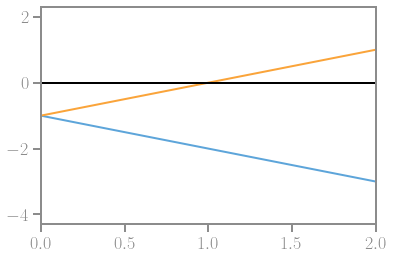

In [35]:
_eq = sp.diff(atk.energy(state), α) \
    .subs({u: _u0, α: α}) \
    .simplify()

_ah = sp.solve(_eq, α)


_ah_f = [sp.lambdify(t, a.subs(_matpar), "numpy") for a in _ah]

# _ahp = sp.lambdify(t, _ah_sub[0].subs(_matpar), "numpy")

_times = np.linspace(0., 3)

for _a in _ah_f:
    plt.plot(_times, [_a(t) for t in _times])

plt.axhline(0, c='k')
plt.xlim(0, _matpar[k])
# plt.plot()

### Check if multiple solutions

In [36]:
state, (_uf, _af) = ana._homogeneous_state(ah = ana._homogeneous_alpha()[1])

1.0


In [37]:
state

{u(x): t*x/L,
 α(x): Piecewise(((-L*w1 + 0.707106781186548*t*sqrt(E0*k*w1))/(L*w1*(k - 1.0)), t >= 1.0), (0, True))}

In [38]:
_ = state[α]

In [39]:
sp.latex(_)

'\\begin{cases} \\frac{- L w_{1} + 0.707106781186548 t \\sqrt{E_{0} k w_{1}}}{L w_{1} \\left(k - 1.0\\right)} & \\text{for}\\: t \\geq 1.0 \\\\0 & \\text{otherwise} \\end{cases}'

In [40]:
_a = state[α]
_a.subs(_matpar)

Piecewise((0.707106781186548*sqrt(2)*t - 1.0, t >= 1.0), (0, True))

In [41]:
_a = state[α]

_ah_f = sp.lambdify(t, _a.subs(_matpar), "numpy")
_ah_f(0)

array(0.)

In [48]:
ana.critical_load_N(_matpar)

1.0

Text(0.5, 1.0, 'Default damage model: atk aka JJK aka LS')

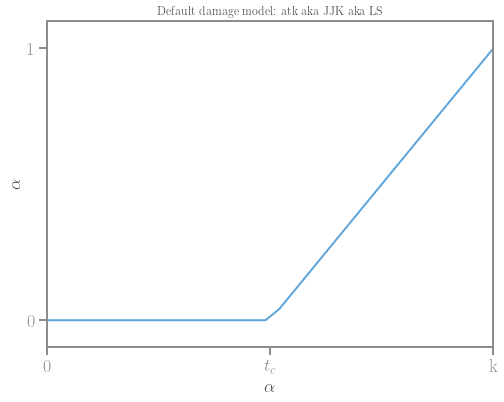

In [50]:
fig, axis = plt.subplots(1, 1, figsize=(8, 6))

axis.plot(_times, [_ah_f(t) for t in _times])
tc = ana.critical_load_N(_matpar)

# axis.axhline(0, c='k')
axis.set_xlim(0, _matpar[k])
axis.set_ylim(-0.1, 1.1)
axis.set_xticks([0, tc, _matpar[k]], ["0", "$t_c$", "k"])
axis.set_yticks([0, 1], ["0", "1"])
axis.set_xlabel("$\\alpha$")
axis.set_ylabel("$\\alpha$")
axis.set_title(f"{ana.model}")


In [51]:
fig.tight_layout()
fig.savefig("../../notes/figures/atk-alpha-homog.pdf")

In [52]:
atk.energy(state)

KeyError: Piecewise(((-L*w1 + 0.707106781186548*t*sqrt(E0*k*w1))/(L*w1*(k - 1.0)), t >= 1.0), (0, True))

In [53]:
_en_h = sp.lambdify(t, atk.energy(_homog_state).subs({α: _homog_state[α]}).subs(_matpar), "numpy")
_en_dam_h = sp.lambdify(t, atk._damage(_homog_state).subs({α: _homog_state[α]}).subs(_matpar), "numpy")
_en_ela_h = sp.lambdify(t, atk._elastic(_homog_state).subs({α: _homog_state[α]}).subs(_matpar), "numpy")

plt.plot(np.linspace(0., 3.), [_en_h(t) for t in np.linspace(0., 3.)], c="C0")
plt.plot(np.linspace(0., 3.), [_en_dam_h(t) for t in np.linspace(0., 3.)], c="C1")
plt.plot(np.linspace(0., 3.), [_en_ela_h(t) for t in np.linspace(0., 3.)], c="C2")


NameError: name '_homog_state' is not defined

<lambdifygenerated-11>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (-_Dummy_209 - 1)/(_Dummy_209 - 1)
<lambdifygenerated-12>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2/(_Dummy_210**2 - 2*_Dummy_210 + 1)
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return -4/(_Dummy_211**3 - 3*_Dummy_211**2 + 3*_Dummy_211 - 1)


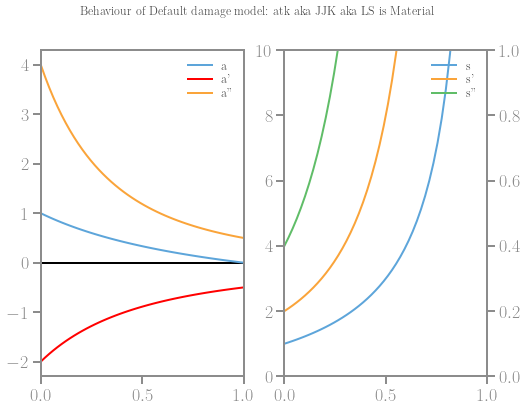

In [54]:
figure, axis = ana.plot_material(_matpar)
# axis[0].set_ylim(-1, 2)
# axis[1].set_ylim(-1, 2)


In [13]:
figure.tight_layout()
figure.savefig("../../notes/figures/atk-model.pdf")

In [112]:
# Localised branches
ana._s, ana._sp.simplify(), ana._spp.simplify()

(((k - 1)*α(x) + 1)/(1 - α(x)),
 k/(α(x)**2 - 2*α(x) + 1),
 -2*k/(α(x)**3 - 3*α(x)**2 + 3*α(x) - 1))

1


(0.0, 100.0)

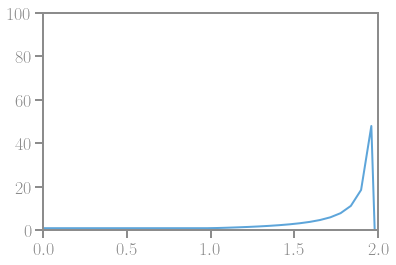

In [258]:
_homog_state, (_uf, _af) = ana._homogeneous_state(_matpar, ah = ana._homogeneous_alpha()[1])


_s = ana._s.subs({α: _homog_state[α]}).subs(_matpar)
_sf = sp.lambdify(t, _s, "numpy")

plt.plot(_times, [_sf(t) for t in _times], c="C0")
plt.xlim(0, _matpar[k])
plt.ylim(0, 100)


1.0


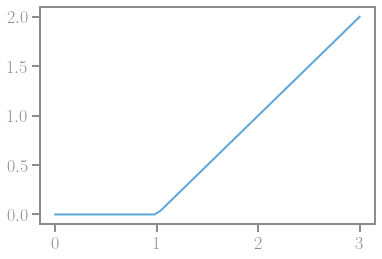

In [252]:
_homog_state, (_uf, _af) = ana._homogeneous_state(_matpar, ah = ana._homogeneous_alpha()[1])


_w = ana._w.subs({α: _homog_state[α]}).subs(_matpar)
_wf = sp.lambdify(t, _w, "numpy")

plt.plot(_times, [_wf(t) for t in _times], c="C0")


<lambdifygenerated-17>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.9801 - 0.9801*(β + 1)/(1 - β)
<lambdifygenerated-18>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.834177777777778 - 0.834177777777778*(β + 1)/(1 - β)
<lambdifygenerated-19>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.700011111111111 - 0.700011111111111*(β + 1)/(1 - β)
<lambdifygenerated-20>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.5776 - 0.5776*(β + 1)/(1 - β)
<lambdifygenerated-21>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.466944444444444 - 0.466944444444444*(β + 1)/(1 - β)
<lambdifygenerated-22>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.368044444444444 - 0.368044444444444*(β + 1)/(1 - β)
<lambdifygenerated-23>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.2809

(-1.0, 2.0)

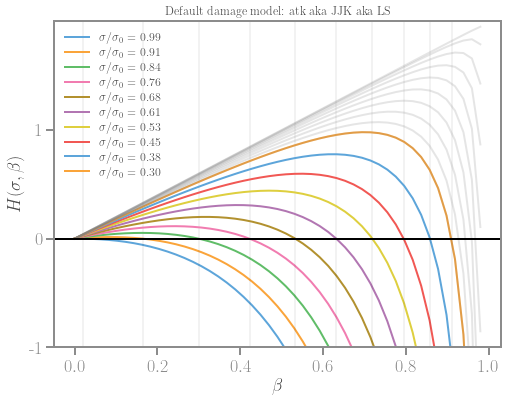

In [19]:
_Hσβ = ana._H_damage_profile().subs(_matpar)

_σ = sp.symbols('σ')
_β = sp.symbols('β')

figure, axis = plt.subplots(1, 1, figsize=(8, 6))


for sigmav in np.linspace(.99, .3, 10):
# for sigmav in np.arange(2, 5):
    _Hβ = _Hσβ.subs({_σ: sigmav})
    # _Hβ = _Hσβ.subs({_σ: 1./k})
    _Hβf = sp.lambdify(_β, _Hβ, "numpy")
    _sol = sp.solve(_Hβ, _β, (0, 1), solver='bisect') 
    αmax = _sol[1][0]
    axis.plot(_damage, [_Hβf(β) for β in _damage], label = f"$\sigma/\sigma_0$  = {sigmav:.2f}")
    # axis.plot(_damage, [_Hβf(β) for β in _damage], label = f"$\sigma/\sigma_0$  = 1/{k:d}")
    axis.axvline(αmax, c='k', lw=.1)

for sigmav in np.linspace(.3, .01, 10):
# for sigmav in np.arange(2, 5):
    _Hβ = _Hσβ.subs({_σ: sigmav})
    # _Hβ = _Hσβ.subs({_σ: 1./k})
    _Hβf = sp.lambdify(_β, _Hβ, "numpy")
    _sol = sp.solve(_Hβ, _β, (0, 1), solver='bisect') 
    αmax = _sol[1][0]
    axis.plot(_damage, [_Hβf(β) for β in _damage], 
        # label = f"$\sigma/\sigma_0$  = {sigmav:.2f}", 
        c='gray',
        alpha = .2
        )
    # axis.plot(_damage, [_Hβf(β) for β in _damage], label = f"$\sigma/\sigma_0$  = 1/{k:d}")
    # axis.axvline(αmax, c='k', lw=.1)



axis.set_ylabel("$H(\\sigma, \\beta)$")
axis.set_xlabel("$\\beta$")
axis.set_title(f"{ana.model}")
axis.legend()
axis.axhline(0, c="k")
axis.set_yticks([-1, 0, 1], ["-1", "0", "1"])
axis.set_ylim(-1, 2)


In [20]:
figure.tight_layout()
figure.savefig("../../notes/figures/atk-Hbeta.pdf")

In [21]:
ana._a

(1 - α(x))/((k - 1)*α(x) + 1)

In [114]:
_Hσβ = ana._H_damage_profile()
_Hσβ
# Linéaire - linéaire (JJK)

(2*β - σ**2*((β*(k - 1) + 1)/(1 - β) - 1/E0))/E0

2*(k - ((k - 1)*α(x) + 1)/(α(x) - 1) - 1)/(α(x) - 1)**2

In [99]:
_Hσβ = ana._H_damage_profile().subs(_matpar)
Hσβ_β = sp.diff(_Hσβ, _β)
Hσβ_β

-2*σ**2/(1 - β)**3 + 2

In [97]:
Hσβ_β.subs({_β: 0})


2 - 2*σ**2

In [82]:
_α0 = sp.symbols('α0')
_γ = sp.symbols('γ')

_Hσβ_α0 = ana._H_damage_profile().subs(_matpar).subs({_β: _α0*_γ})
_Hσβ_α0


2*α0*γ - σ**2*(-1 + (α0*γ + 1)/(-α0*γ + 1))

In [123]:
sp.diff(_Hσβ_α0, _γ)


-2*α0 + 2*σ**2/(α0**2*γ**3)

In [17]:
amax = []
for i in np.linspace(.99, .3, 10):
    amax.append(ana._α_max(i, _matpar))


amax

[0.0199,
 0.16582222222222223,
 0.2999888888888889,
 0.4224,
 0.5330555555555555,
 0.6319555555555556,
 0.7191,
 0.7944888888888889,
 0.8581222222222222,
 0.91]

In [114]:
for a in amax:
    _Hσβ_α0.subs({_α0: a})
    # print(a, _Hσβ_α0)

Text(0.5, 1.0, 'Default damage model: atk aka JJK aka LS')

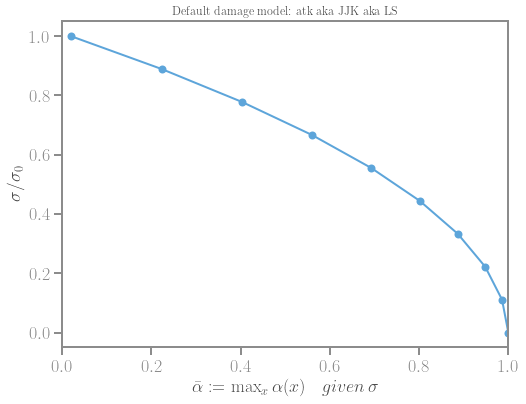

In [22]:

figure, axis = plt.subplots(1, 1, figsize=(8, 6))

amax = []
for i in np.linspace(.99, .01, 10):
    amax.append(ana._α_max(i, _matpar))


axis.plot(amax, np.linspace(1, .0, 10), marker='o')
axis.set_xlabel('$\\bar \\alpha := \\max_x \\alpha(x) \\quad given\, \\sigma$')
axis.set_ylabel('$\\sigma/\\sigma_0$')
axis.set_xlim(0., 1.)
axis.set_title(f"{ana.model}")

# plt.plot(np.linspace(-.99, -.2, 10), amax)

In [23]:
figure.tight_layout()
figure.savefig("../../notes/figures/atk-maxalpha.pdf")

In [25]:
matpar

{k: k, E0: E0, w1: w1, η: η, L: L}

In [26]:
ana.snap_back(_matpar) < 0

True

In [258]:
_Hσγ = ana._H_damage_profile().subs(_matpar).subs({_β: _α0*_γ})
Hσγ_γ = sp.diff(_Hσγ, _γ)
# Hσγ_γ.simplify().subs({_γ: 1})
Hσγ_γ

2*α0 - σ**2*(α0/(-α0*γ + 1) + α0*(α0*γ + 1)/(-α0*γ + 1)**2)

## ATn

In [212]:
## Simple Analytic 
# import visuals

E0, L, w1, 𝓁, σc = sp.symbols('E0 L w1 𝓁 σc')
x, t = sp.symbols('x t')
α = sp.Function('α')(x)
u = sp.Function('u')(x)

n = sp.symbols('n')


#### ATn, n=1 => AT1

In [240]:
state = {u: u, α: α}
matpar = {n: 1, E0: 1, w1: 1, 𝓁:𝓁}
_matpar = {n: 1, L: 1, E0: 1, w1: 1, 𝓁:𝓁}

at1 = DamageATn(state, matpar={n: 1, E0: E0, w1: w1, 𝓁:𝓁, L: L}, name="At1 Damage Model", slug=f"at1")
ana = ModelAnalysis(model = at1)

_ = ana.criterion()
_
# ana.critical_load()
# ana._homogeneous_alpha()
print(ana.model)


At1 Damage Model


In [241]:
ana.model.slug

'at1'

In [242]:
ana._print_model_functions()
ana._print_model_functions(_matpar)

Output in model-at1.txt
0=
t_c=
H(\sigma, \beta)=
H(\sigma, \gamma)=
1/\sqrt{H(\sigma, \beta)}=
(S(\beta)-S_0)/\sqrt{H(\sigma, \beta)}=
(S(\gamma)-S_0)/\sqrt{H(\sigma, \gamma)}=
Output in model-at1-matpar.txt
0=
t_c=
H(\sigma, \beta)=
H(\sigma, \gamma)=
1/\sqrt{H(\sigma, \beta)}=
(S(\beta)-S_0)/\sqrt{H(\sigma, \beta)}=
(S(\gamma)-S_0)/\sqrt{H(\sigma, \gamma)}=


In [118]:
_ = ana.model.energy(ana.model.state)
# , α) \
#     .subs({u: _u0, α: _alpha0})         \
#     .simplify()

In [119]:
# sp.solve(ana.crit, t)
_ = ana.critical_load()

In [120]:
_

L*sqrt(1/E0)

In [83]:
sp.latex(_)

'L \\sqrt{\\frac{1}{E_{0}}}'

In [121]:
ana.criterion()

-1.0*E0*t**2/L**2 + 1

In [122]:
ana._critical_load

L*sqrt(1/E0)

In [123]:
ana.critical_load_N(_matpar)

1.0

Text(0.5, 1.0, 'At1 Damage Model')

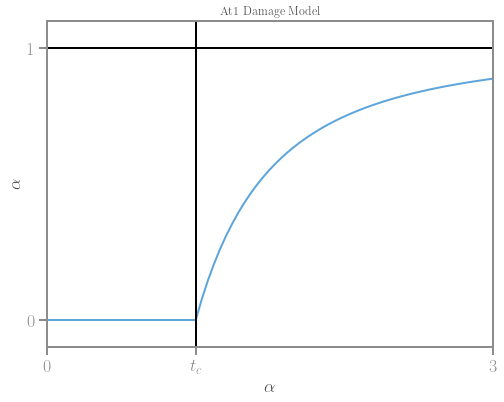

In [124]:

figure, axis = ana.plot_homogeneous_alpha(_matpar)
axis.set_ylim(-0.1, 1)

# axis.axhline(0, c='k')
axis.set_xlim(0, 3)
axis.set_ylim(-0.1, 1.1)
axis.set_xticks([0, ana.critical_load_N(_matpar), 3], ["0", "$t_c$", "3"])
axis.set_yticks([0, 1], ["0", "1"])
axis.set_xlabel("$\\alpha$")
axis.set_ylabel("$\\alpha$")
axis.set_title(f"{ana.model}")

In [ ]:
figure.tight_layout()
figure.savefig("../../notes/figures/at1-alpha-homog.pdf")

_tc 1.0
1.0


TypeError: Argument must be a Basic object, not `list`

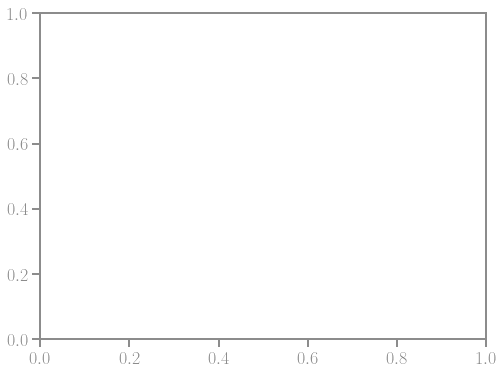

In [126]:

figure, axis = ana.plot_homogeneous_stress(_matpar)


# axis.axhline(0, c='k')
axis.set_xlim(0, 3)
axis.set_ylim(-0.1, 1.1)
axis.set_xticks([0, ana.critical_load_N(_matpar), 3], ["0", "$t_c$", "3"])
axis.set_yticks([0, 1], ["0", "1"])
axis.set_xlabel("$t$")
axis.set_ylabel("$\\sigma$")
axis.set_title(f"{ana.model}")

In [ ]:
_homog_state, (_uf, _af) = ana._homogeneous_state(_matpar)
_ = _homog_state[α]


1.0


In [ ]:
sp.latex(_)

'\\begin{cases} 1 - \\frac{L^{2}}{E_{0} t^{2}} & \\text{for}\\: t \\geq 1.0 \\\\0 & \\text{otherwise} \\end{cases}'

In [ ]:
at1.energy({u: _homog_state[u], α: _homog_state[α]})

0.5*E0*t**2*(1 - Piecewise((1 - L**2/(E0*t**2), t >= 1.0), (0, True)))**2/L**2 + α(x)

<lambdifygenerated-509>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 0.5*t**2*(1 - select([greater_equal(t, 1.0),True], [1 - 1/t**2,0], default=nan))**2 + select([greater_equal(t, 1.0),True], [1 - 1/t**2,0], default=nan)
<lambdifygenerated-510>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return select([greater_equal(t, 1.0),True], [1 - 1/t**2,0], default=nan)
<lambdifygenerated-511>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 0.5*t**2*(1 - select([greater_equal(t, 1.0),True], [1 - 1/t**2,0], default=nan))**2


Text(0.5, 1.0, 'At1 Damage Model')

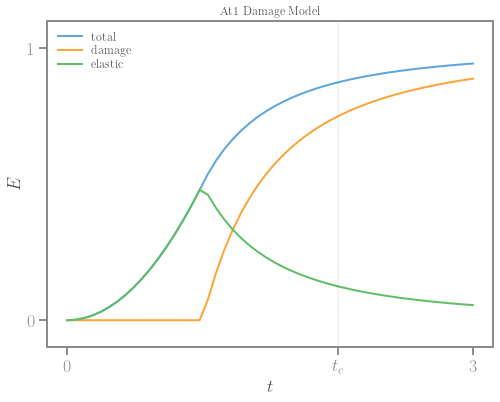

In [ ]:

figure, axis = plt.subplots(1, 1, figsize=(8, 6))


_en_h = sp.lambdify(t, at1.energy(_homog_state).subs({α: _homog_state[α]}).subs(_matpar), "numpy")
_en_dam_h = sp.lambdify(t, at1._damage(_homog_state).subs({α: _homog_state[α]}).subs(_matpar), "numpy")
_en_ela_h = sp.lambdify(t, at1._elastic(_homog_state).subs({α: _homog_state[α]}).subs(_matpar), "numpy")

axis.plot(np.linspace(0., 3.), [_en_h(t) for t in np.linspace(0., 3.)], c="C0", label = "total")
axis.plot(np.linspace(0., 3.), [_en_dam_h(t) for t in np.linspace(0., 3.)], c="C1", label = "damage")
axis.plot(np.linspace(0., 3.), [_en_ela_h(t) for t in np.linspace(0., 3.)], c="C2", label = "elastic")
axis.axvline(np.float64(tc), c='k', lw=.1)
axis.legend()


axis.set_ylim(-0.1, 1.1)
axis.set_xticks([0, tc, 3], ["0", "$t_c$", "3"])
axis.set_yticks([0, 1], ["0", "1"])
axis.set_xlabel("$t$")
axis.set_ylabel("$E$")
axis.set_title(f"{ana.model}")


In [ ]:
figure.tight_layout()
figure.savefig("../../notes/figures/at1-energies-homog.pdf")

<lambdifygenerated-27>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (_Dummy_1254 - 1)**(-2.0)
<lambdifygenerated-28>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return -2/(_Dummy_1255 - 1)**3
<lambdifygenerated-29>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 6/(_Dummy_1256 - 1)**4


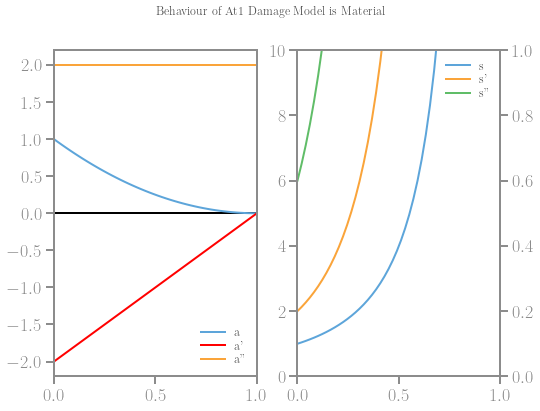

In [86]:
figure, axis = ana.plot_material(_matpar)

In [21]:
figure.tight_layout()
figure.savefig("../../notes/figures/at1-model.pdf")

#### Localised branches


In [131]:
_σ = sp.symbols('σ')
_β = sp.symbols('β')

1.0


<lambdifygenerated-3>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2/(1 - select([greater_equal(t, 1.0),True], [1 - 1/t**2,0], default=nan))**3


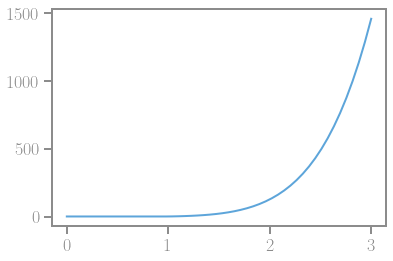

In [20]:
_homog_state, (_uf, _af) = ana._homogeneous_state(_matpar)


_s = ana._sp.subs({α: _homog_state[α]}).subs(_matpar)
_sf = sp.lambdify(t, _s, "numpy")

plt.plot(_times, [_sf(t) for t in _times], c="C0")


$$E_0 H(\sigma, \beta) = 2w(\beta) - \sigma^2 (S(\beta)-S_0))$$

with
$$\eta^2 \alpha'(x)^2 = H(\sigma, \alpha(x)) \qquad \qquad x\in S_i$$

$$e_\text{loc}(\sigma)=\int_0^{\bar \alpha(\sigma)} \frac{S(\beta)-S_0}{\sqrt{2w(\beta) - \sigma^2(S(\beta)-S_0))}}d\beta$$

In [132]:
_α0 = sp.symbols('α0')
_γ = sp.symbols('γ')

_Hσβ_α0 = ana._H_damage_profile().subs(_matpar).subs({_β: _α0*_γ})
_Hσβ_α0


2*α0*γ - σ**2*(-1 + (-α0*γ + 1)**(-2))

In [944]:
sp.diff(ana._s, α) \
    .subs({α: 0})

2

<lambdifygenerated-50>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.9801 - 0.9801/(1 - β)**2
<lambdifygenerated-51>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.776356790123457 - 0.776356790123457/(1 - β)**2
<lambdifygenerated-52>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.596327160493827 - 0.596327160493827/(1 - β)**2
<lambdifygenerated-53>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.440011111111111 - 0.440011111111111/(1 - β)**2
<lambdifygenerated-54>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.307408641975309 - 0.307408641975309/(1 - β)**2
<lambdifygenerated-55>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.19851975308642 - 0.19851975308642/(1 - β)**2
<lambdifygenerated-56>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.11334444444444

(-1.0, 2.0)

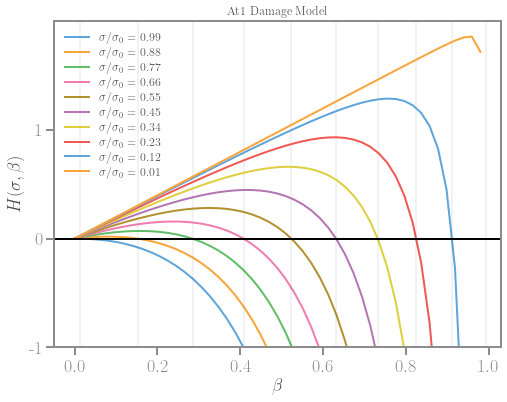

In [94]:
_Hσβ = ana._H_damage_profile().subs(_matpar)

_σ = sp.symbols('σ')
_β = sp.symbols('β')

figure, axis = plt.subplots(1, 1, figsize=(8, 6))


for k in np.linspace(.99, .01, 10):
# for k in np.arange(2, 5):
    _Hβ = _Hσβ.subs({_σ: k})
    # _Hβ = _Hσβ.subs({_σ: 1./k})
    _Hβf = sp.lambdify(_β, _Hβ, "numpy")
    _sol = sp.solve(_Hβ, _β, (0, 1), solver='bisect') 
    αmax = _sol[1][0]
    axis.plot(_damage, [_Hβf(β) for β in _damage], label = f"$\sigma/\sigma_0$  = {k:.2f}")
    # axis.plot(_damage, [_Hβf(β) for β in _damage], label = f"$\sigma/\sigma_0$  = 1/{k:d}")
    axis.axvline(αmax, c='k', lw=.1)



axis.set_ylabel("$H(\\sigma, \\beta)$")
axis.set_xlabel("$\\beta$")
axis.set_title(f"{ana.model}")
axis.legend()
axis.axhline(0, c="k")
axis.set_yticks([-1, 0, 1], ["-1", "0", "1"])
axis.set_ylim(-1, 2)


In [95]:
figure.tight_layout()
figure.savefig("../../notes/figures/at1-Hbeta.pdf")

In [24]:
_f = ana._H_damage_profile().subs({_σ: σv}).subs(_matpar)
_f

2*β + 0.25 - 0.25/(1 - β)**2

In [160]:
sp.diff(ana._H_damage_profile(), _β).subs({_β: _β-_αmax})

(-0.279612883414931*σ**2/(1 - 0.519010002130596*β)**3 + 2)/E0

In [26]:

_f = 1/sp.sqrt(ana._H_damage_profile()).subs({_σ: σv}).subs(_matpar)
_f
_Dσ =  sp.integrate(_f, (_β, 0, _αmax))


In [27]:
_Dσ

0.365148371670111*sqrt(2)*Integral(1/(sqrt(β)*sqrt(0.533333333333333*β**2/(β**2 - 2*β + 1) - 1.0*β/(β**2 - 2*β + 1) + 0.4/(β**2 - 2*β + 1))), (β, 0, 0.578464834591373))

In [30]:
_matpar

{n: 1, L: 1, E0: 1, w1: 1, η: η}

In [134]:
_f = (1/sp.sqrt(
    ana._H_damage_profile().subs(_matpar))
    ).simplify()
_f

1/sqrt(2*β + σ**2 - σ**2/(β - 1)**2)

In [28]:
_f = (1/sp.sqrt(
    ana._H_damage_profile().subs(_matpar))
    ).subs({_σ: σv}).simplify()
_f

sqrt(2)/(2*sqrt(β + 0.125 - 0.125/(β - 1)**2))

In [29]:
_fv = sp.lambdify(_β, _f, "numpy")
_beta = np.linspace(0.001, np.float64(_αmax)-0.001, 30)
# _beta
[_fv(b) for b in _beta];

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


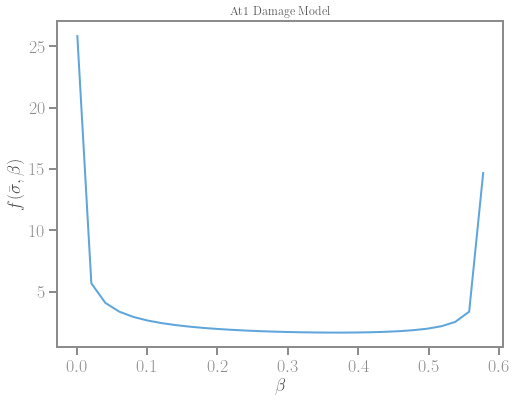

In [30]:
figure, axis = plt.subplots(1, 1, figsize=(8, 6))

axis.plot(_beta, [_fv(b) for b in _beta])


axis.set_ylabel("$f(\\bar\\sigma, \\beta)$")
axis.set_xlabel("$\\beta$")
axis.set_title(f"{ana.model}")
axis.legend()
# axis.axhline(0, c="k")
# axis.set_yticks([-1, 0, 1], ["-1", "0", "1"])
# axis.set_ylim(-1, 1)


In [31]:
np.trapz([_fv(b) for b in _beta], _beta)

1.6773480170312964

In [66]:
_f = ((ana._s - 1/E0).subs(α, _β)/sp.sqrt(ana._H_damage_profile()))    \
    .subs(_matpar)                                              \
    .simplify()

_f



(1 - (β - 1)**2)/(sqrt((2*β*(β - 1)**2 + σ**2*((β - 1)**2 - 1))/(β - 1)**2)*(β - 1)**2)

In [123]:
# _f = 1/sp.sqrt(ana._H_damage_profile()).subs({_σ: σv}).subs(_matpar)

σv = .9

_αmax = ana._α_max(σv, _matpar)


_betas = np.linspace(0.001, np.float64(_αmax)-0.001, 30)

_fv = sp.lambdify(_β, _f.subs({_σ: σv}), "numpy")


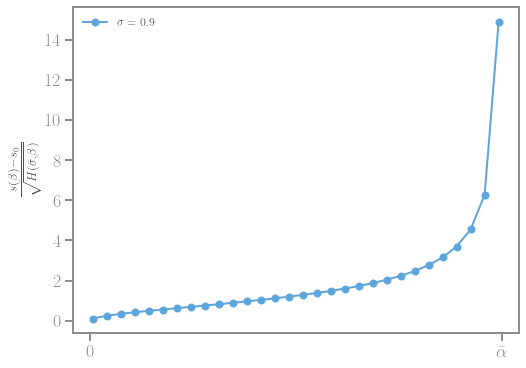

In [133]:
figure, axis = plt.subplots(1, 1, figsize=(8, 6))

axis.plot(_betas, [_fv(b) for b in _betas], marker = 'o', label = f"$\\sigma = {σv}$")
axis.set_xticks([0, _αmax], ["0", "$\\bar\\alpha$"])
axis.set_ylabel("$\\frac{s(\\beta)-s_0}{\\sqrt{H(\\bar \\sigma, \\beta)}}$")

axis.legend()


In [146]:
_f = ((ana._s - 1/E0).subs(α, _β)/sp.sqrt(ana._H_damage_profile()))    \
    .subs(_matpar)                                              \
    .simplify()

_f

(1 - (β - 1)**2)/(sqrt((2*β*(β - 1)**2 + σ**2*((β - 1)**2 - 1))/(β - 1)**2)*(β - 1)**2)

In [ ]:
figure, axis = plt.subplots(1, 1, figsize=(8, 6))
_tol = 1e-4


_N = 30
for σv in np.linspace(.99, .01, 10):
#  = .9
    _αmax = ana._α_max(σv, _matpar)
    _betas = np.linspace(_tol, np.float64(_αmax)-_tol, _N)

    _fv = sp.lambdify(_β, _f.subs({_σ: σv}), "numpy")
    axis.plot([_fv(b) for b in _betas], marker = 'o', label = f"$\sigma/\sigma_0$  = {σv:.2f}")

axis.set_ylabel("$\\frac{s(\\beta)-s_0}{\\sqrt{H(\\bar \\sigma, \\beta)}}$")
axis.set_xlabel("$\\beta/\\bar \\alpha$")
axis.set_ylim(0, 100)
axis.set_xticks([0, _N], ["0", "1"])
axis.legend()


In [150]:
_fsqrth


1/sqrt(2*β + σ**2 - σ**2/(β - 1)**2)

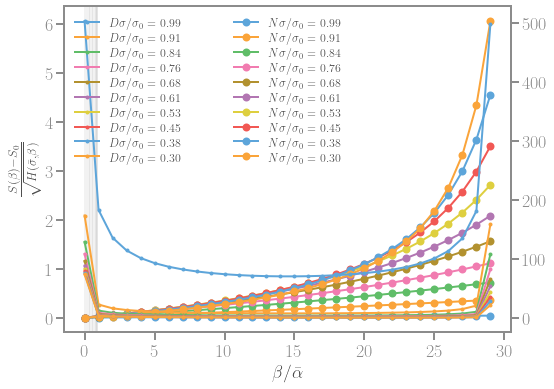

In [80]:
figure, axis = plt.subplots(1, 1, figsize=(8, 6))
_tol = 1e-4

_fsqrth_d = (1/sp.sqrt(ana._H_damage_profile()))    \
    .subs(_matpar)                                              \
    .simplify()

# _fsqrth = (_σ*(ana._s - 1/E0).subs(α, _β)/sp.sqrt(ana._H_damage_profile()))    \
#     .subs(_matpar)                                              \
#     .simplify()

_fsqrth_n = (_σ*(ana._s - 1/E0).subs(α, _β))    \
    .subs(_matpar)                                              \
    .simplify()

ax_2 = axis.twinx()
_N = 30
for σv in np.linspace(.99, .3, 10):
#  = .9
    _αmax = ana._α_max(σv, _matpar)
    _betas = np.linspace(_tol, np.float64(_αmax)-_tol, _N)

    _fvn = sp.lambdify(_β, _fsqrth_n.subs({_σ: σv}), "numpy")
    _fvd = sp.lambdify(_β, _fsqrth_d.subs({_σ: σv}), "numpy")
    axis.plot([_fvn(b) for b in _betas], marker = 'o', label = f"$N \sigma/\sigma_0$  = {σv:.2f}")
    ax_2.plot([_fvd(b) for b in _betas], marker = '.', label = f"$D \sigma/\sigma_0$  = {σv:.2f}")
    axis.axvline(_αmax, c='k', lw=.1)

axis.set_ylabel("$\\frac{S(\\beta)-S_0}{\\sqrt{H(\\bar \\sigma, \\beta)}}$")
axis.set_xlabel("$\\beta/\\bar \\alpha$")
# axis.set_ylim(0, 100)
# axis.set_xticks([0, _N], ["0", "1"])
axis.legend()
ax_2.legend(loc=2)


In [68]:
ana.model.energy(state)

0.5*E0*(1 - α(x))*Derivative(u(x), x)**2/((k - 1)*α(x) + 1) + w1*(η**2*Derivative(α(x), x)**2 + α(x))

In [56]:
np.trapz([_fv(b) for b in _betas], _betas)


7.7120505153983405

In [110]:
def _eps_1_d(sigma, tol = 1e-3):
    _α_max = ana._α_max(sigma, _matpar)
    _f = (ana._s - 1/E0).subs(α, _β)/sp.sqrt(ana._H_damage_profile())    \
        .subs(_matpar)                                                   \
        .subs({_σ: σv})                                                   \
        .simplify()

    __fv = sp.lambdify(_β, f.subs(_matpar), "numpy")
    # _tol = 0.001
    _betas = np.linspace(_tol, _α_max-_tol, 30)
    eps = np.trapz([__fv(b) for b in _betas], _betas)

    return eps, (_f, _α_max)

def _eps_1_d_integrand(sigma, matpar, tol = 1e-3):
    _α_max = ana._α_max(sigma, matpar)
    _f = ((ana._s - 1/E0).subs(α, _β)/sp.sqrt(ana._H_damage_profile()))    \
        .subs(matpar)                                                   \
        .subs({_σ: sigma})                                                   \
        .simplify()

    __fv = sp.lambdify(_β, f.subs(matpar), "numpy")

    return _f, _α_max, __fv




In [149]:
_f.simplify()


(1 - (β - 1)**2)/(sqrt((2*β*(β - 1)**2 + σ**2*((β - 1)**2 - 1))/(β - 1)**2)*(β - 1)**2)

In [151]:
_f = ((ana._s - 1/E0).subs(α, _β)/sp.sqrt(ana._H_damage_profile()))    \
.subs(matpar)                                                   \
.simplify()                                                 \
.subs({_σ: .9})                                                   \

_f 

__fv = sp.lambdify(_β, _f, "numpy")

_tol = 1e-3
_betas = np.linspace(_tol, amax-_tol, 30)

plt.plot(_betas, [__fv(b) for b in _betas], marker='o')



In [133]:
_eps_sigma = []
sigmas = np.linspace(1., 0.01, 10)

for sv in sigmas:
    print(f"sv {sv}")
    f, amax, fv = _eps_1_d_integrand(sv, _matpar)
    _tol = 1e-3

    _betas = np.linspace(_tol, amax-_tol, 30)
    [fv(b) for b in _betas]
    # _eps = np.trapz([fv(b) for b in _betas], _betas)
    # _eps_sigma.append(_eps)



sv 1.0
[(0.0, (0.0, 1.0)), (1.50000000000000, (0.0, 1.0))]
sv 0.89
[(0.0, (0.0, 1.0)), (0.142229669872533, (0.0, 1.0)), (1.46172033012747, (0.0, 1.0))]
sv 0.78
[(0.0, (0.0, 1.0)), (0.275768537834179, (0.0, 1.0)), (1.42003146216582, (0.0, 1.0))]
sv 0.6699999999999999
[(0.0, (0.0, 1.0)), (0.400902890894334, (0.0, 1.0)), (1.37464710910567, (0.0, 1.0))]
sv 0.56
[(0.0, (0.0, 1.0)), (0.517933603082942, (0.0, 1.0)), (1.32526639691706, (0.0, 1.0))]
sv 0.44999999999999996
[(0.0, (0.0, 1.0)), (0.627174921438557, (0.0, 1.0)), (1.27157507856144, (0.0, 1.0))]
sv 0.33999999999999997
[(0.0, (0.0, 1.0)), (0.728952916598196, (0.0, 1.0)), (1.21324708340180, (0.0, 1.0))]


<lambdifygenerated-175>:2: RuntimeWarning: invalid value encountered in sqrt
  return (1/2)*sqrt(2)*(-1 + (1 - β)**(-2.0))/sqrt(β + 0.5 - 0.5/(β - 1)**2)
<lambdifygenerated-176>:2: RuntimeWarning: invalid value encountered in sqrt
  return (1/2)*sqrt(2)*(-1 + (1 - β)**(-2.0))/sqrt(β + 0.39605 - 0.39605/(β - 1)**2)
<lambdifygenerated-177>:2: RuntimeWarning: invalid value encountered in sqrt
  return (1/2)*sqrt(2)*(-1 + (1 - β)**(-2.0))/sqrt(β + 0.3042 - 0.3042/(β - 1)**2)
<lambdifygenerated-178>:2: RuntimeWarning: invalid value encountered in sqrt
  return (1/2)*sqrt(2)*(-1 + (1 - β)**(-2.0))/sqrt(β + 0.22445 - 0.22445/(β - 1)**2)
<lambdifygenerated-179>:2: RuntimeWarning: invalid value encountered in sqrt
  return (1/2)*sqrt(2)*(-1 + (1 - β)**(-2.0))/sqrt(β + 0.1568 - 0.1568/(β - 1)**2)
<lambdifygenerated-180>:2: RuntimeWarning: invalid value encountered in sqrt
  return (1/2)*sqrt(2)*(-1 + (1 - β)**(-2.0))/sqrt(β + 0.10125 - 0.10125/(β - 1)**2)


sv 0.22999999999999998
[(0.0, (0.0, 1.0)), (0.823603615790023, (0.0, 1.0)), (1.14994638420998, (0.0, 1.0))]
sv 0.12
[(0.0, (0.0, 1.0)), (0.911470853059742, (0.0, 1.0)), (1.08132914694026, (0.0, 1.0))]
sv 0.01
[(0.0, (0.0, 1.0)), (0.992903887994099, (0.0, 1.0)), (1.00704611200590, (0.0, 1.0))]


<lambdifygenerated-181>:2: RuntimeWarning: invalid value encountered in sqrt
  return (1/2)*sqrt(2)*(-1 + (1 - β)**(-2.0))/sqrt(β + 0.0578 - 0.0578/(β - 1)**2)
<lambdifygenerated-182>:2: RuntimeWarning: invalid value encountered in sqrt
  return (1/2)*sqrt(2)*(-1 + (1 - β)**(-2.0))/sqrt(β + 0.02645 - 0.02645/(β - 1)**2)
<lambdifygenerated-183>:2: RuntimeWarning: invalid value encountered in sqrt
  return (1/2)*sqrt(2)*(-1 + (1 - β)**(-2.0))/sqrt(β + 0.0072 - 0.0072/(β - 1)**2)


Behaviour around $\beta=0$

$$\frac{\partial f}{\partial \beta}|_{\beta=0}$$

with $f = 1/\sqrt{H(\sigma, \beta)}$

In [196]:
sp.diff(_f, _β).simplify().subs({ _β: 0})

E0*(1 - σ**2)/(σ**2*sqrt(-σ**2*(E0 - 1)/E0**2)*(E0 - 1))

Text(0.5, 1.0, 'Default damage model: atk aka JJK aka LS')

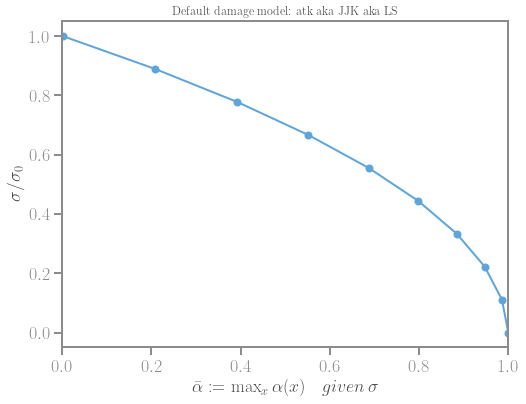

In [29]:

figure, axis = plt.subplots(1, 1, figsize=(8, 6))

amax = []
for i in np.linspace(.999, .01, 10):
    amax.append(ana._α_max(i, _matpar))


axis.plot(amax, np.linspace(1, .0, 10), marker='o')
axis.set_xlabel('$\\bar \\alpha := \\max_x \\alpha(x) \\quad given\, \\sigma$')
axis.set_ylabel('$\\sigma/\\sigma_0$')
axis.set_xlim(0., 1.)
axis.set_title(f"{ana.model}")

# plt.plot(np.linspace(-.99, -.2, 10), amax)

In [92]:
figure.tight_layout()
figure.savefig("../../notes/figures/at1-maxalpha.pdf")

In [93]:
ana.snap_back(matpar) < 0

True

In [37]:
ana._eps_1_d_integrand(.99, _matpar)

(-sqrt(2)*β/(sqrt(β*(β - 0.0199)/(β - 1))*(β - 1)),
 0.0199,
 <function _lambdifygenerated(β)>)

sv 0.99 amax 0.0199
sv 0.9355555555555556 amax 0.1247358024691358
sv 0.8811111111111111 amax 0.223643209876543
sv 0.8266666666666667 amax 0.31662222222222225
sv 0.7722222222222223 amax 0.40367283950617283
sv 0.7177777777777778 amax 0.484795061728395
sv 0.6633333333333333 amax 0.559988888888889
sv 0.6088888888888889 amax 0.629254320987654
sv 0.5544444444444445 amax 0.692591358024691
sv 0.5 amax 0.75


[0.03178712269387426,
 0.2662253945182205,
 0.5293871380052814,
 0.8154939899224676,
 1.1239530894313192,
 1.455768359976769,
 1.813134383383416,
 2.1995070166140964,
 2.6199405885049387,
 3.0817327592932178]

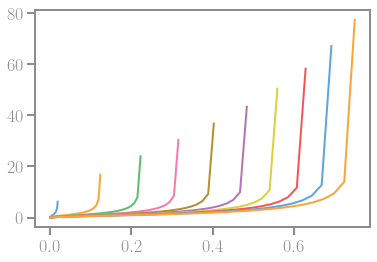

In [43]:
_eps_sigma = []
sigmas = np.linspace(.99, 0.5, 10)

for sv in sigmas:
    f, amax, fv = ana._eps_1_d_integrand(sv, _matpar)
    print(f"sv {sv} amax {amax}")
    _tol = 1e-3

    _betas = np.linspace(_tol, amax-_tol, 30)
    [fv(b) for b in _betas]
    plt.plot(_betas, [fv(b) for b in _betas])
    _eps = np.trapz([fv(b) for b in _betas], _betas)
    _eps_sigma.append(_eps)

_eps_sigma


In [54]:
np.linspace(.99, .3, 10)[::-1]

array([0.3       , 0.37666667, 0.45333333, 0.53      , 0.60666667,
       0.68333333, 0.76      , 0.83666667, 0.91333333, 0.99      ])

<lambdifygenerated-89>:2: RuntimeWarning: invalid value encountered in sqrt
  return -sqrt(2)*β/(sqrt(β*(β - 0.75)/(β - 1))*(β - 1))
<lambdifygenerated-89>:2: RuntimeWarning: invalid value encountered in sqrt
  return -sqrt(2)*β/(sqrt(β*(β - 0.75)/(β - 1))*(β - 1))
<lambdifygenerated-89>:2: RuntimeWarning: invalid value encountered in sqrt
  return -sqrt(2)*β/(sqrt(β*(β - 0.75)/(β - 1))*(β - 1))


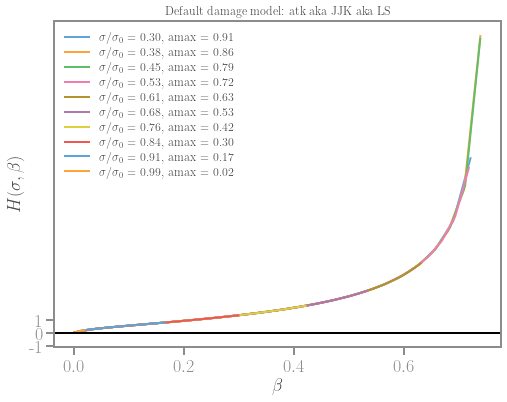

In [56]:

figure, axis = plt.subplots(1, 1, figsize=(8, 6))


for sigmav in np.linspace(.99, .3, 10)[::-1]:
# for sigmav in np.arange(2, 5):
    # _Hβ = _Hσβ.subs({_σ: sigmav})
    # _Hβ = _Hσβ.subs({_σ: 1./k})
    # _Hβf = sp.lambdify(_β, _Hβ, "numpy")
    # _sol = sp.solve(_Hβ, _β, (0, 1), solver='bisect') 
    # αmax = _sol[1][0]
    
    amax = ana._α_max(sigmav, _matpar)
    _betas = np.linspace(_tol, amax-_tol, 30)
    # print(_betas)
    # axis.plot(_betas, _betas, label = f"$\sigma/\sigma_0$  = {sigmav:.2f}, amax = {amax:.2f}")
    axis.plot(_betas, [fv(β) for β in _betas], label = f"$\sigma/\sigma_0$  = {sigmav:.2f}, amax = {amax:.2f}")
    # axis.axvline(αmax, c='k', lw=.1)

# for sigmav in np.linspace(.3, .01, 10):
#     amax = ana._α_max(sigmav, _matpar)
#     _betas = np.linspace(_tol, amax-_tol, 30)

#     axis.plot(_betas, [fv(β) for β in _betas], 
#         c='gray',
#         alpha = .2
#         )



axis.set_ylabel("$H(\\sigma, \\beta)$")
axis.set_xlabel("$\\beta$")
axis.set_title(f"{ana.model}")
axis.legend()
axis.axhline(0, c="k")
axis.set_yticks([-1, 0, 1], ["-1", "0", "1"])
# axis.set_ylim(-1, 2)


## PQ

In [243]:
state = {u: u, α: α}
p, q, E0, L, w1, 𝓁, σc = sp.symbols('p q E0 L w1 𝓁 σc')

matpar = {p: p, q: q, E0: E0, L: L, w1: w1, 𝓁:𝓁, σc: σc}
_matpar = {p: 1, q: 1, E0: 1, L: 1, w1: 2, 𝓁:𝓁, σc: 1}
# _matpar = {n: 1, L: 1, E0: 1, w1: 1, 𝓁:𝓁}

dpq = DamagePQ(state, matpar=matpar, name="PQ Damage Model", slug = "pq")
ana = ModelAnalysis(model = dpq)
_ = ana.criterion().simplify()
_

-(p + q)*(0.5*E0**2*t**2 - L**2*w1*σc**2)/(E0*L**2)

In [244]:
ana._print_model_functions()
ana._print_model_functions(_matpar)

Output in model-pq.txt
0=
t_c=
H(\sigma, \beta)=
H(\sigma, \gamma)=
1/\sqrt{H(\sigma, \beta)}=
(S(\beta)-S_0)/\sqrt{H(\sigma, \beta)}=
(S(\gamma)-S_0)/\sqrt{H(\sigma, \gamma)}=
Output in model-pq-matpar.txt
0=
t_c=
H(\sigma, \beta)=
H(\sigma, \gamma)=
1/\sqrt{H(\sigma, \beta)}=
(S(\beta)-S_0)/\sqrt{H(\sigma, \beta)}=
(S(\gamma)-S_0)/\sqrt{H(\sigma, \gamma)}=


In [246]:
_ = ana.model.energy(ana.model.state)
_

0.5*E0*(1 - α(x))**q*Derivative(u(x), x)**2/(α(x) + 1)**p + w1*(𝓁**2*Derivative(α(x), x)**2 + σc**2*(p + q)*α(x)/E0)

In [866]:
sp.latex(_)

'0.5 E_{0} \\left(1 - α{\\left(x \\right)}\\right)^{q} \\left(α{\\left(x \\right)} + 1\\right)^{- p} \\left(\\frac{d}{d x} u{\\left(x \\right)}\\right)^{2} + w_{1} \\left(η^{2} \\left(\\frac{d}{d x} α{\\left(x \\right)}\\right)^{2} + \\frac{σc^{2} \\left(p + q\\right) α{\\left(x \\right)}}{E_{0}}\\right)'

In [867]:
_ = ana.criterion()
_

(p + q)*(-0.5*E0**2*t**2/L**2 + w1*σc**2)/E0

In [868]:
sp.latex(_)

'\\frac{\\left(p + q\\right) \\left(- \\frac{0.5 E_{0}^{2} t^{2}}{L^{2}} + w_{1} σc^{2}\\right)}{E_{0}}'

In [247]:
[np.float(t.subs(_matpar).subs({L: 1})) for t in sp.solve(ana.crit, t)]

/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_14570/972471254.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  [np.float(t.subs(_matpar).subs({L: 1})) for t in sp.solve(ana.crit, t)]


[-2.0, 2.0]

In [873]:
ana._critical_load

1.4142135623731*L*sqrt(w1)*σc/E0

In [248]:
ana.critical_load_N(_matpar)

2.0

In [876]:
_ = ana.model.energy(ana.model.state)
# , α) \
#     .subs({u: _u0, α: _alpha0})         \
#     .simplify()

In [877]:
sp.latex(_)

'0.5 E_{0} \\left(1 - α{\\left(x \\right)}\\right)^{q} \\left(α{\\left(x \\right)} + 1\\right)^{- p} \\left(\\frac{d}{d x} u{\\left(x \\right)}\\right)^{2} + w_{1} \\left(η^{2} \\left(\\frac{d}{d x} α{\\left(x \\right)}\\right)^{2} + \\frac{σc^{2} \\left(p + q\\right) α{\\left(x \\right)}}{E_{0}}\\right)'

In [878]:
_eq = sp.diff(dpq.energy(state), α) \
    .subs({u: _u0, α: α}) \
    .simplify()

In [879]:
# _ = _eq.subs(_matpar).subs({p: 2, q: 1}).simplify()
_ = _eq.subs(_matpar).simplify()

In [883]:
_ = ana._homogeneous_alpha(_matpar)[1]
_

0.5*t - 1.0

In [885]:
ana.crit
ana.critical_load()

1.4142135623731*L*sqrt(w1)*σc/E0

In [886]:
tc = ana.critical_load().subs(_matpar)


In [887]:
state, (_uf, _af) = ana._homogeneous_state(ah = ana._homogeneous_alpha(_matpar)[1])

1.4142135623731*L*sqrt(w1)*σc/E0


In [888]:
_a = state[α]

_ah_f = sp.lambdify(t, _a.subs(_matpar), "numpy")
_ah_f(0)

array(0.)

In [889]:
print(ana.model)

PQ Damage Model


Text(0.5, 1.0, 'PQ Damage Model')

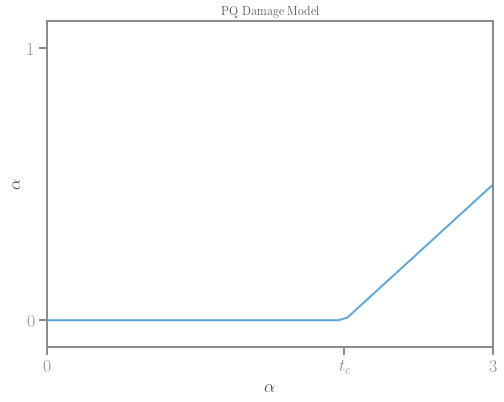

In [890]:
figure, axis = plt.subplots(1, 1, figsize=(8, 6))

axis.plot(_times, [_ah_f(t) for t in _times])
tc = ana.critical_load().subs(_matpar)

# axis.axhline(0, c='k')
axis.set_xlim(0, 3)
axis.set_ylim(-0.1, 1.1)
axis.set_xticks([0, tc, 3], ["0", "$t_c$", "3"])
axis.set_yticks([0, 1], ["0", "1"])
axis.set_xlabel("$\\alpha$")
axis.set_ylabel("$\\alpha$")
axis.set_title(f"{ana.model}")


In [891]:
figure.tight_layout()
figure.savefig("../../notes/figures/pq-alpha-homog.pdf")

In [894]:
ana._s.subs(_matpar)

(α(x) + 1)/(1 - α(x))

<lambdifygenerated-413>:2: RuntimeWarning: invalid value encountered in double_scalars
  return 2*(1 - _Dummy_13314)/((_Dummy_13314**2 - 1)*(_Dummy_13314 + 1))
<lambdifygenerated-414>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (2*(_Dummy_13315 - 1)**2 - 2*(_Dummy_13315 - 1)*(_Dummy_13315 + 1))/((1 - _Dummy_13315)*(_Dummy_13315 + 1)**3)
<lambdifygenerated-415>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (_Dummy_13316 + 1)/(1 - _Dummy_13316)
<lambdifygenerated-416>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return -2*(_Dummy_13317 + 1)/((1 - _Dummy_13317)*(_Dummy_13317**2 - 1))
<lambdifygenerated-417>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (-2*(_Dummy_13318 - 1)*(_Dummy_13318 + 1) + 2*(_Dummy_13318 + 1)**2)/((1 - _Dummy_13318)**3*(_Dummy_13318 + 1))


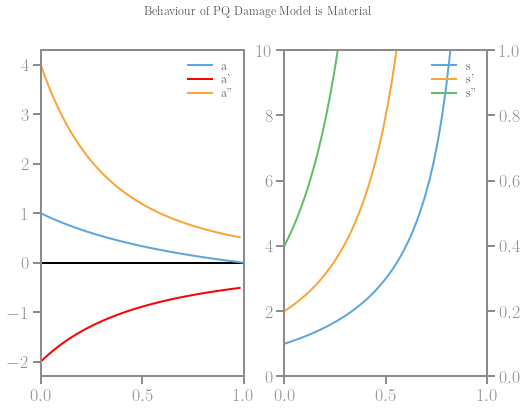

In [892]:
figure, axis = ana.plot_material(_matpar)

In [860]:
dpq.energy({u: _homog_state[u], α: _homog_state[α]})

0.5*E0*t**2*(1 - Piecewise((1 - L**2/(E0*t**2), t >= 1.0), (0, True)))**q/(L**2*(Piecewise((1 - L**2/(E0*t**2), t >= 1.0), (0, True)) + 1)**p) + w1*σc**2*(p + q)*α(x)/E0

In [225]:
ana._deps_1_d_dσ()

-8.88576587631673*E0*(p + q)**2/(2*p*q + p*(p - 1) + q*(q + 1))**1.5

In [159]:
ana._deps_1_d_dσ() \
    .subs({E0: 1, σc: 1})

-8.88576587631673*(p + q)**2/(p**3 + 3*p**2*q - 3*p**2 + 3*p*q**2 + 2*p + q**3 + 3*q**2 + 2*q)**1.5

Playground

ATk

In [356]:


state = {u: u, α: α}
_matpar = {k: 2, E0: 1, w1: 1, 𝓁:𝓁, L: 1}
matpar = {k: k, E0: 1, w1: w1, 𝓁:𝓁, L: L}

_u0 = t*x/L
_alpha0 = 0 

atk = DefaultDamage(state, _matpar)


ana = ModelAnalysis(atk)
_crit = sp.diff(atk.energy(state), α).subs({u: _u0, α: _alpha0}).simplify()
_crit

# atk = DefaultDamage(state, matpar)
ana = ModelAnalysis(atk)
ana.criterion()
ana.set_critical_load(ana.critical_load_N(_matpar)[0][0])
# ana._critical_load
ana._homogeneous_state(ah = ana._homogeneous_alpha()[1])


1


({u(x): t*x/L, α(x): Piecewise((-1.0 + t/(L*sqrt(w1)), t >= 1), (0, True))},
 (<function _lambdifygenerated(t, x)>, <function _lambdifygenerated(t)>))

(0.0, 2.0)

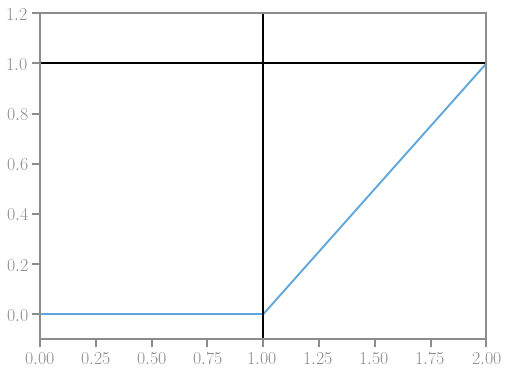

In [357]:

fig, ax = ana.plot_homogeneous_alpha(_matpar)
ax.set_ylim(-0.1, 1.2)
ax.set_xlim(0, _matpar[k])


In [358]:
_stress = ana._stress(ah = ana._homogeneous_alpha()[1]).simplify()


1


In [359]:
_stress.subs(ana.model.matpar)

Piecewise((2.0*sqrt((1 - 0.5*t)**2), t >= 1), (t, True))

(0.0, 2.0)

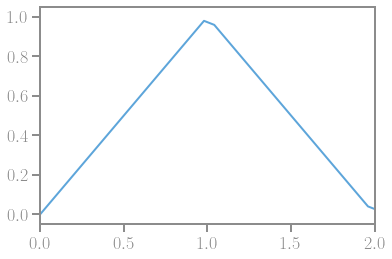

In [360]:
_sh_f = sp.lambdify(t, _stress.subs(ana.model.matpar), "numpy")
plt.plot(_times, [_sh_f(t) for t in _times])
plt.xlim(0, _matpar[k])



<lambdifygenerated-485>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1 - _Dummy_13386)**3*(2*_Dummy_13386 + 4)/((_Dummy_13386**2 - 1)*(_Dummy_13386 + 1))
<lambdifygenerated-487>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (_Dummy_13388 + 1)/(1 - _Dummy_13388)**3
<lambdifygenerated-488>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (-2*_Dummy_13389 - 4)*(_Dummy_13389 + 1)/((1 - _Dummy_13389)**3*(_Dummy_13389**2 - 1))
<lambdifygenerated-489>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (-6*(_Dummy_13390 - 1)*(_Dummy_13390 + 1) + 12*(_Dummy_13390 + 1)**2)/((1 - _Dummy_13390)**5*(_Dummy_13390 + 1))


(0.0, 20.0)

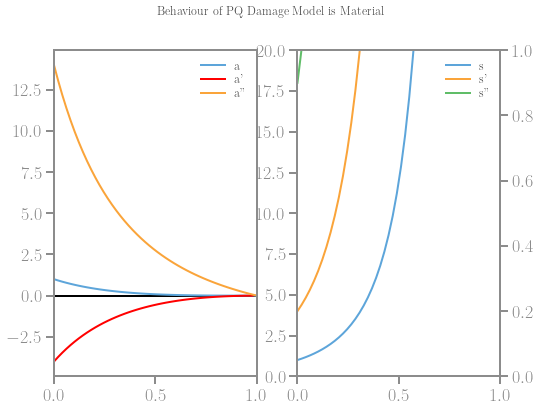

In [911]:
_matpar = {p: 1, q: 3, E0: 1, L: 1, w1: 2, 𝓁:𝓁, σc: 1}

figure, axis = ana.plot_material(_matpar)
axis[1].set_ylim(0, 20)

In [912]:
figure.tight_layout()
figure.savefig("../../notes/figures/pq-13-model.pdf")

<lambdifygenerated-490>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 8*β + 0.9801 - 0.9801*(β + 1)/(1 - β)**3
<lambdifygenerated-491>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 8*β + 0.814004938271605 - 0.814004938271605*(β + 1)/(1 - β)**3
<lambdifygenerated-492>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 8*β + 0.66331975308642 - 0.66331975308642*(β + 1)/(1 - β)**3
<lambdifygenerated-493>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 8*β + 0.528044444444444 - 0.528044444444444*(β + 1)/(1 - β)**3
<lambdifygenerated-494>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 8*β + 0.408179012345679 - 0.408179012345679*(β + 1)/(1 - β)**3
<lambdifygenerated-495>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 8*β + 0.303723456790123 - 0.303723456790123*(β + 1)/(1 - β)**3
<lambdifygenerated-496>:2: RuntimeWarning: divide by zero encoun

(-1.0, 1.0)

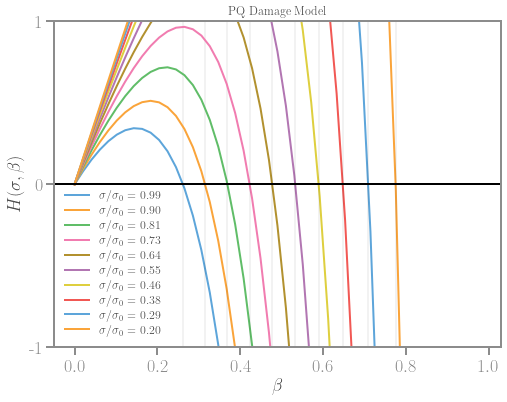

In [913]:
_Hσβ = ana._H_damage_profile().subs(_matpar)

_σ = sp.symbols('σ')
_β = sp.symbols('β')

figure, axis = plt.subplots(1, 1, figsize=(8, 6))


for k in np.linspace(.99, .2, 10):
# for k in np.arange(2, 5):
    _Hβ = _Hσβ.subs({_σ: k})
    # _Hβ = _Hσβ.subs({_σ: 1./k})
    _Hβf = sp.lambdify(_β, _Hβ, "numpy")
    _sol = sp.solve(_Hβ, _β, (0, 1), solver='bisect') 
    αmax = _sol[1][0]
    axis.plot(_damage, [_Hβf(β) for β in _damage], label = f"$\sigma/\sigma_0$  = {k:.2f}")
    # axis.plot(_damage, [_Hβf(β) for β in _damage], label = f"$\sigma/\sigma_0$  = 1/{k:d}")
    axis.axvline(αmax, c='k', lw=.1)



axis.set_ylabel("$H(\\sigma, \\beta)$")
axis.set_xlabel("$\\beta$")
axis.set_title(f"{ana.model}")
axis.legend()
axis.axhline(0, c="k")
axis.set_yticks([-1, 0, 1], ["-1", "0", "1"])
axis.set_ylim(-1, 1)


In [914]:
figure.tight_layout()
figure.savefig("../../notes/figures/pq-Hbeta.pdf")

[(0.0, (0.0, 1.0)), (0.256342907249954, (0.0, 1.0)), (1.30945348387502 - 0.489635550830775*I, (0.0, 1.0)), (1.30945348387502 + 0.489635550830775*I, (0.0, 1.0))]
[(0.0, (0.0, 1.0)), (0.323413251550169, (0.0, 1.0)), (1.28888596373109 - 0.456774461543913*I, (0.0, 1.0)), (1.28888596373109 + 0.456774461543913*I, (0.0, 1.0))]
[(0.0, (0.0, 1.0)), (0.390680695657565, (0.0, 1.0)), (1.26671044769591 - 0.421889531798422*I, (0.0, 1.0)), (1.26671044769591 + 0.421889531798422*I, (0.0, 1.0))]
[(0.0, (0.0, 1.0)), (0.458543099353957, (0.0, 1.0)), (1.24272800587858 - 0.384624146147038*I, (0.0, 1.0)), (1.24272800587858 + 0.384624146147038*I, (0.0, 1.0))]
[(0.0, (0.0, 1.0)), (0.527541270663190, (0.0, 1.0)), (1.21666823426717 - 0.344479626039208*I, (0.0, 1.0)), (1.21666823426717 + 0.344479626039208*I, (0.0, 1.0))]
[(0.0, (0.0, 1.0)), (0.598459768873767, (0.0, 1.0)), (1.18813885321744 - 0.300718945908265*I, (0.0, 1.0)), (1.18813885321744 + 0.300718945908265*I, (0.0, 1.0))]
[(0.0, (0.0, 1.0)), (0.67254413176

Text(0.5, 1.0, 'PQ Damage Model')

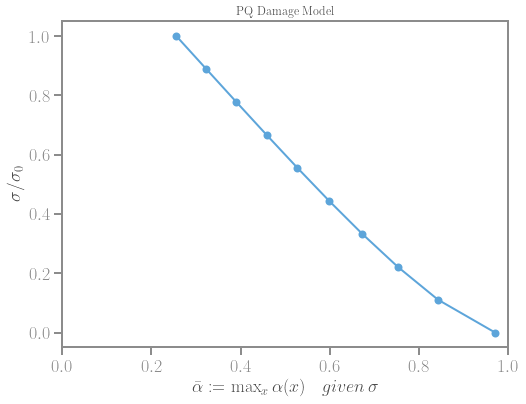

In [916]:

figure, axis = plt.subplots(1, 1, figsize=(8, 6))

amax = []
for i in np.linspace(.999, .01, 10):
    amax.append(ana._α_max(i, _matpar))


axis.plot(amax, np.linspace(1, .0, 10), marker='o')
axis.set_xlabel('$\\bar \\alpha := \\max_x \\alpha(x) \\quad given\, \\sigma$')
axis.set_ylabel('$\\sigma/\\sigma_0$')
axis.set_xlim(0., 1.)
axis.set_title(f"{ana.model}")


In [917]:
figure.tight_layout()
figure.savefig("../../notes/figures/pq-maxalpha.pdf")

<lambdifygenerated-503>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 0.5*t**2*(1 - select([greater_equal(t, 1.0),True], [1 - 1/t**2,0], default=nan))**2 + 2*select([greater_equal(t, 1.0),True], [1 - 1/t**2,0], default=nan)
<lambdifygenerated-504>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*select([greater_equal(t, 1.0),True], [1 - 1/t**2,0], default=nan)
<lambdifygenerated-505>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 0.5*t**2*(1 - select([greater_equal(t, 1.0),True], [1 - 1/t**2,0], default=nan))**2


Text(0.5, 1.0, 'PQ Damage Model')

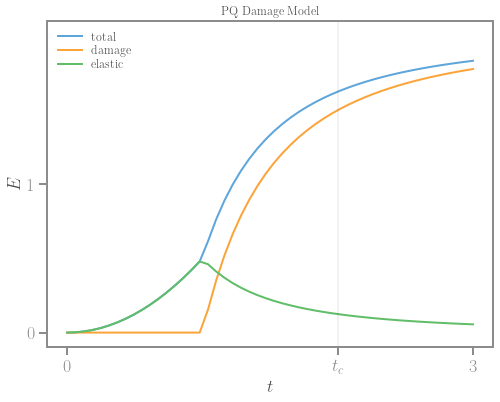

In [919]:

figure, axis = plt.subplots(1, 1, figsize=(8, 6))


_en_h = sp.lambdify(t, at1.energy(_homog_state).subs({α: _homog_state[α]}).subs(_matpar), "numpy")
_en_dam_h = sp.lambdify(t, at1._damage(_homog_state).subs({α: _homog_state[α]}).subs(_matpar), "numpy")
_en_ela_h = sp.lambdify(t, at1._elastic(_homog_state).subs({α: _homog_state[α]}).subs(_matpar), "numpy")

axis.plot(np.linspace(0., 3.), [_en_h(t) for t in np.linspace(0., 3.)], c="C0", label = "total")
axis.plot(np.linspace(0., 3.), [_en_dam_h(t) for t in np.linspace(0., 3.)], c="C1", label = "damage")
axis.plot(np.linspace(0., 3.), [_en_ela_h(t) for t in np.linspace(0., 3.)], c="C2", label = "elastic")
axis.axvline(np.float64(tc), c='k', lw=.1)
axis.legend()


axis.set_ylim(-0.1, 2.1)
axis.set_xticks([0, tc, 3], ["0", "$t_c$", "3"])
axis.set_yticks([0, 1], ["0", "1"])
axis.set_xlabel("$t$")
axis.set_ylabel("$E$")
axis.set_title(f"{ana.model}")


In [920]:
figure.tight_layout()
figure.savefig("../../notes/figures/pq-energies-homog.pdf")

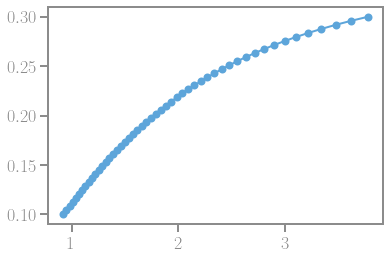

In [363]:
_σ = sp.symbols('σ')
_β = sp.symbols('β')
sigmav = .8

_f = ((ana._s - 1/E0).subs({α: _β}) * 1/sp.sqrt(ana._H_damage_profile()))    \
    .subs(ana.model.matpar)                                                \
    .subs({_σ: sigmav, 𝓁: .1})
_fvβ = sp.lambdify(_β, _f, "numpy")


# _α_max = ana._α_max(sigmav)
# 
# print(_α_max.subs(ana.model.matpar))

_x = np.linspace(0.1, .3)
_fvβ(_x)
plt.plot(_fvβ(_x), _x, marker='o')


# np

PQ

In [384]:
p, q, E0, L, w1, 𝓁, σc = sp.symbols('p q E0 L w1 𝓁 σc')


state = {u: u, α: α}
_matpar = {k: 2, E0: 1, w1: 1, 𝓁:𝓁, L: 1, p: 2, q: 2, σc: 1}
matpar = {k: k, E0: 1, w1: w1, 𝓁:𝓁, L: L}

_u0 = t*x/L
_alpha0 = 0 

dpq = DamagePQ(state, matpar={}, name="pq")


ana = ModelAnalysis(dpq)
_crit = sp.diff(dpq.energy(state), α).subs({u: _u0, α: _alpha0}).simplify()
_crit

# dpq = DefaultDamage(state, matpar)
ana = ModelAnalysis(dpq)
ana.criterion()
# ana.set_critical_load(ana.critical_load_N(_matpar)[0][0])
# ana._critical_load
# ana._homogeneous_state(ah = ana._homogeneous_alpha()[1])


(p + q)*(-0.5*E0**2*t**2/L**2 + w1*σc**2)/E0

In [385]:
sp.solve(ana.crit, t**2)

[2.0*L**2*w1*σc**2/E0**2]

In [386]:
ana.crit

(p + q)*(-0.5*E0**2*t**2/L**2 + w1*σc**2)/E0

In [367]:
sp.solve(ana.crit, t**2)

[2.0*L**2*w1*σc**2/E0**2]

In [369]:
sp.solve(ana.crit, t**2)

[2.0*L**2*w1*σc**2/E0**2]

In [375]:
ana.model._matpar

{p: p, q: q, E0: E0, w1: w1, η: η, L: L, σc: σc}

In [378]:
_eq = sp.diff(ana.model.energy(state), α) \
                .subs({u: _u0, α: α})         \
                .simplify().subs(_matpar)

_ah = sp.solve(_eq, α)

In [388]:
ana._homogeneous_alpha(matpar = _matpar)

[0.209986841649146*t**2/(-t**2 + (0.0185185185185185*t**6 + t**4)**0.5)**(1/3) - 0.7937005259841*(-t**2 + (0.0185185185185185*t**6 + t**4)**0.5)**(1/3) - 1.0,
 0.209986841649146*t**2*(-0.5 - 0.866025403784439*I)/(-t**2 + (0.0185185185185185*t**6 + t**4)**0.5)**(1/3) - 0.7937005259841*(-0.5 + 0.866025403784439*I)*(-t**2 + (0.0185185185185185*t**6 + t**4)**0.5)**(1/3) - 1.0,
 0.209986841649146*t**2*(-0.5 + 0.866025403784439*I)/(-t**2 + (0.0185185185185185*t**6 + t**4)**0.5)**(1/3) - 0.7937005259841*(-0.5 - 0.866025403784439*I)*(-t**2 + (0.0185185185185185*t**6 + t**4)**0.5)**(1/3) - 1.0]

In [389]:
_u0

t*x/L

<lambdifygenerated-203>:2: RuntimeWarning: invalid value encountered in double_scalars
  return 0.209986841649146*t**2/(-t**2 + sqrt(0.0185185185185185*t**6 + t**4))**(1/3) - 0.7937005259841*(-t**2 + sqrt(0.0185185185185185*t**6 + t**4))**(1/3) - 1.0
<lambdifygenerated-204>:2: RuntimeWarning: invalid value encountered in cdouble_scalars
  return 0.209986841649146*t**2*(-0.5 - 0.866025403784439*1j)/(-t**2 + sqrt(0.0185185185185185*t**6 + t**4))**(1/3) - 0.7937005259841*(-0.5 + 0.866025403784439*1j)*(-t**2 + sqrt(0.0185185185185185*t**6 + t**4))**(1/3) - 1.0
/opt/homebrew/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
<lambdifygenerated-205>:2: RuntimeWarning: invalid value encountered in cdouble_scalars
  return 0.209986841649146*t**2*(-0.5 + 0.866025403784439*1j)/(-t**2 + sqrt(0.0185185185185185*t**6 + t**4))**(1/3) - 0.7937005259841*(-0.5 - 0.866025403784439*1j)*(-t

(0.0, 2.0)

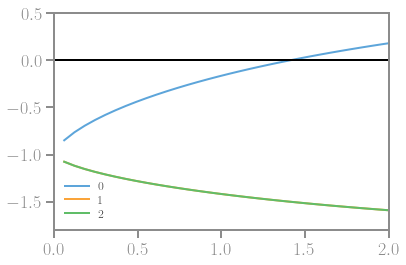

In [395]:
_eq = sp.diff(dpq.energy(state), α) \
    .subs({u: _u0, α: α}) \
    .simplify().subs(_matpar)

_ah = sp.solve(_eq, α)


_ah_f = [sp.lambdify(t, a.subs(_matpar), "numpy") for a in _ah]

# _ahp = sp.lambdify(t, _ah_sub[0].subs(_matpar), "numpy")

_times = np.linspace(0., 3)

for _i, _a in enumerate(_ah_f):
    plt.plot(_times, [_a(t) for t in _times], label=_i)
plt.legend()

plt.axhline(0, c='k')
plt.xlim(0, _matpar[k])
# plt.plot()

In [397]:
ana._homogeneous_state(ah = ana._homogeneous_alpha(matpar = _matpar)[0])


AttributeError: 'ModelAnalysis' object has no attribute '_critical_load'

In [400]:
ana.critical_load_N(_matpar)[0][0]

1

In [402]:
ana.critical_load()

[2.0*L**2*w1*σc**2/E0**2]

In [96]:

def plot_H_(matpar):
    """docstring for plot_H_"""
        
    _Hσβ = ana._H_damage_profile().subs(matpar)


    _σ = sp.symbols('σ')
    _β = sp.symbols('β')

    figure, axis = plt.subplots(1, 1, figsize=(8, 6))


    for sigmav in np.linspace(.99, .3, 10):
        _Hβ = _Hσβ.subs({_σ: sigmav})
        _Hβf = sp.lambdify(_β, _Hβ, "numpy")
        _sol = sp.solve(_Hβ, _β, (0, 1), solver='bisect') 
        αmax = _sol[1][0]
        axis.plot(_damage, [_Hβf(β) for β in _damage], label = f"$\sigma/\sigma_0$  = {sigmav:.2f}")
        axis.axvline(αmax, c='k', lw=.1)

    for sigmav in np.linspace(.3, .01, 10):
        _Hβ = _Hσβ.subs({_σ: sigmav})
        _Hβf = sp.lambdify(_β, _Hβ, "numpy")
        _sol = sp.solve(_Hβ, _β, (0, 1), solver='bisect') 
        αmax = _sol[1][0]
        axis.plot(_damage, [_Hβf(β) for β in _damage], 
            c='gray',
            alpha = .2
            )


    axis.set_ylabel("$H(\\sigma, \\beta)$")
    axis.set_xlabel("$\\beta$")
    axis.set_title(f"{ana.model}")
    axis.legend()
    axis.axhline(0, c="k")
    axis.set_yticks([-1, 0, 1], ["-1", "0", "1"])
    axis.set_ylim(-1, 2)
    
    return figure, axis

def plot_max_alpha(matpar):
    """docstring for plot_max_alpha"""
    figure, axis = plt.subplots(1, 1, figsize=(8, 6))

    amax = []
    for i in np.linspace(.99, .01, 10):
        amax.append(ana._α_max(i, matpar))

    axis.plot(amax, np.linspace(1, .0, 10), marker='o')
    axis.set_xlabel('$\\bar \\alpha := \\max_x \\alpha(x) \\quad given\, \\sigma$')
    axis.set_ylabel('$\\sigma/\\sigma_0$')
    axis.set_xlim(0., 1.)
    axis.set_title(f"{ana.model}")
    
    return figure, axis


### Generic analysis

In [91]:
print(ana.model)

At1 Damage Model


In [104]:
_α0 = sp.symbols('α0')
_γ = sp.symbols('γ')

_Hσβ_α0 = ana._H_damage_profile().subs(_matpar).subs({_β: _α0*_γ})
_Hσβ_α0


4*α0*γ - σ**2*(-1 + (α0*γ + 1)/(-α0*γ + 1))

<lambdifygenerated-430>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 4*β + 0.9801 - 0.9801*(β + 1)/(1 - β)
<lambdifygenerated-431>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 4*β + 0.834177777777778 - 0.834177777777778*(β + 1)/(1 - β)
<lambdifygenerated-432>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 4*β + 0.700011111111111 - 0.700011111111111*(β + 1)/(1 - β)
<lambdifygenerated-433>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 4*β + 0.5776 - 0.5776*(β + 1)/(1 - β)
<lambdifygenerated-434>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 4*β + 0.466944444444444 - 0.466944444444444*(β + 1)/(1 - β)
<lambdifygenerated-435>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 4*β + 0.368044444444444 - 0.368044444444444*(β + 1)/(1 - β)
<lambdifygenerated-436>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 4*β +

(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:title={'center':'PQ Damage Model'}, xlabel='$\\beta$', ylabel='$H(\\sigma, \\beta)$'>)

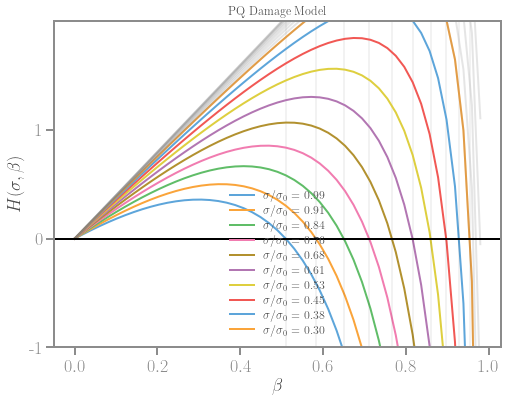

In [101]:
plot_H_(_matpar)

(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:title={'center':'At1 Damage Model'}, xlabel='$\\bar \\alpha := \\max_x \\alpha(x) \\quad given\\, \\sigma$', ylabel='$\\sigma/\\sigma_0$'>)

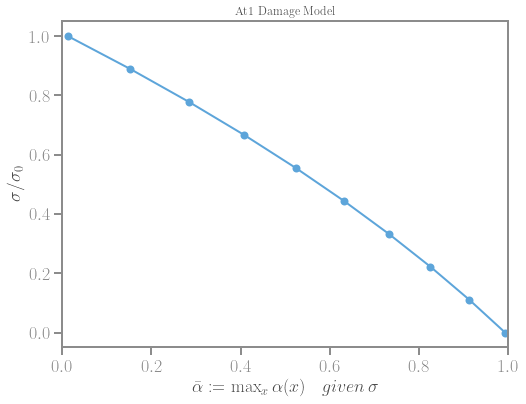

In [97]:
plot_max_alpha(_matpar)

<lambdifygenerated-601>:2: RuntimeWarning: invalid value encountered in sqrt
  return (1/2)*sqrt(2)/sqrt(β*(2*β - 1.0199)/(β - 1))
<lambdifygenerated-603>:2: RuntimeWarning: invalid value encountered in sqrt
  return (1/2)*sqrt(2)/sqrt(β*(2*β - 1.20592098765432)/(β - 1))
<lambdifygenerated-605>:2: RuntimeWarning: invalid value encountered in sqrt
  return (1/2)*sqrt(2)/sqrt(β*(2*β - 1.37238395061728)/(β - 1))
<lambdifygenerated-607>:2: RuntimeWarning: invalid value encountered in sqrt
  return (1/2)*sqrt(2)/sqrt(β*(2*β - 1.51928888888889)/(β - 1))
<lambdifygenerated-609>:2: RuntimeWarning: invalid value encountered in sqrt
  return (1/2)*sqrt(2)/sqrt(β*(2*β - 1.64663580246914)/(β - 1))
<lambdifygenerated-611>:2: RuntimeWarning: invalid value encountered in sqrt
  return (1/2)*sqrt(2)/sqrt(β*(2*β - 1.75442469135802)/(β - 1))
<lambdifygenerated-613>:2: RuntimeWarning: invalid value encountered in sqrt
  return (1/2)*sqrt(2)/sqrt(β*(2*β - 1.84265555555556)/(β - 1))
<lambdifygenerated-615>

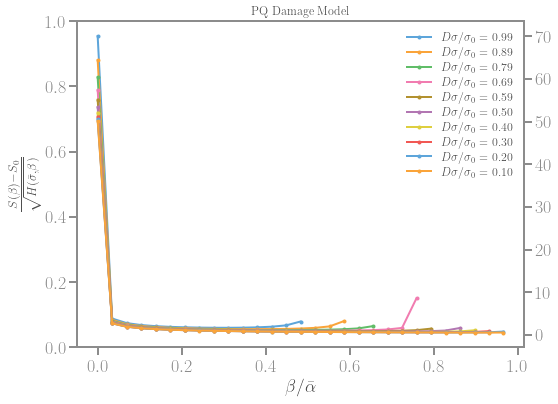

In [113]:
_α0 = sp.symbols('α0')

figure, axis = plt.subplots(1, 1, figsize=(8, 6))
_tol = 1e-4

_fsqrth_d = (1/sp.sqrt(ana._H_damage_profile()))    \
    .subs(_matpar)                                              \
    .simplify()

# _fsqrth = (_σ*(ana._s - 1/E0).subs(α, _β)/sp.sqrt(ana._H_damage_profile()))    \
#     .subs(_matpar)                                              \
#     .simplify()

_fsqrth_n = (_σ*(ana._s - 1/E0).subs(α, _α0*_β))    \
    .subs(_matpar)                                              \
    .simplify()

ax_2 = axis.twinx()
_N = 30
for σv in np.linspace(.99, .1, 10):
#  = .9
    _αmax = ana._α_max(σv, _matpar)
    # _betas = np.linspace(_tol, np.float64(_αmax)-_tol, _N)
    _betas = np.linspace(_tol, 1.-_tol, _N)

    _fvn = sp.lambdify(_β, _fsqrth_n.subs({_σ: σv, _α0: _αmax}), "numpy")
    _fvd = sp.lambdify(_β, _fsqrth_d.subs({_σ: σv, _α0: _αmax}), "numpy")
    # axis.plot(_betas, [_fvn(b) for b in _betas], marker = 'o', label = f"$N \sigma/\sigma_0$  = {σv:.2f}")
    ax_2.plot(_betas, [_fvd(b) for b in _betas], marker = '.', label = f"$D \sigma/\sigma_0$  = {σv:.2f}")
    # axis.axvline(_αmax, c='k', lw=.1)

axis.set_ylabel("$\\frac{S(\\beta)-S_0}{\\sqrt{H(\\bar \\sigma, \\beta)}}$")
axis.set_xlabel("$\\beta/\\bar \\alpha$")
# axis.set_ylim(0, 100)
# axis.set_xticks([0, _N], ["0", "1"])
axis.legend()
axis.set_title(f"{ana.model}")

ax_2.legend(loc=1)
